## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


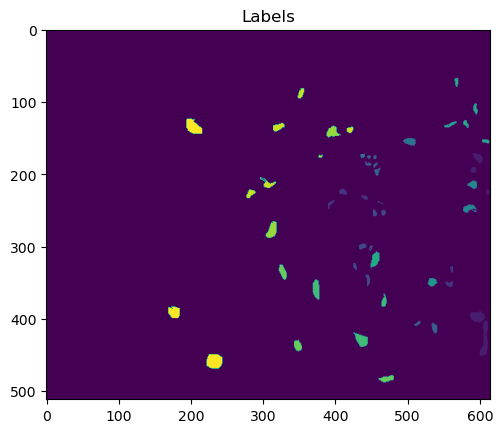

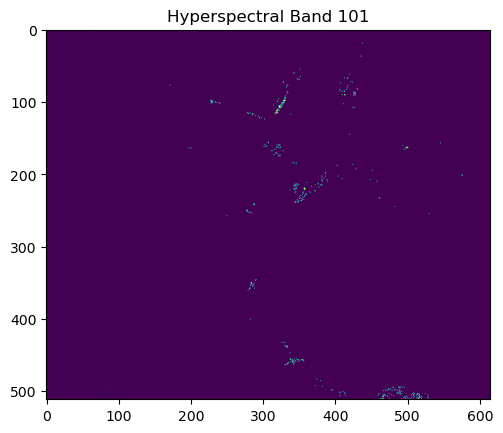

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(130, 5, 5, 176)
(65, 5, 5, 176)
(5016, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 130
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2504, PSNR: 6.0136


Epoch [1/50] Training Loss: 0.2395, PSNR: 5.5321
	[Val]   Batch [1/17] Loss: 0.2254, PSNR: 6.4709
	[Val]   Batch [10/17] Loss: 0.2256, PSNR: 6.4658
Epoch [1/50] Validation Loss: 0.2255, PSNR: 6.4683

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2223, PSNR: 6.5307


Epoch [2/50] Training Loss: 0.2031, PSNR: 6.9295
	[Val]   Batch [1/17] Loss: 0.1798, PSNR: 7.4523
	[Val]   Batch [10/17] Loss: 0.1816, PSNR: 7.4085
Epoch [2/50] Validation Loss: 0.1808, PSNR: 7.4284

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1802, PSNR: 7.4426


Epoch [3/50] Training Loss: 0.1661, PSNR: 7.1211
	[Val]   Batch [1/17] Loss: 0.1448, PSNR: 8.3928
	[Val]   Batch [10/17] Loss: 0.1472, PSNR: 8.3208
Epoch [3/50] Validation Loss: 0.1462, PSNR: 8.3521

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1461, PSNR: 8.3543


Epoch [4/50] Training Loss: 0.1338, PSNR: 8.7423
	[Val]   Batch [1/17] Loss: 0.1161, PSNR: 9.3501
	[Val]   Batch [10/17] Loss: 0.1171, PSNR: 9.3147
Epoch [4/50] Validation Loss: 0.1167, PSNR: 9.3299

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1165, PSNR: 9.3357


Epoch [5/50] Training Loss: 0.1066, PSNR: 9.7282
	[Val]   Batch [1/17] Loss: 0.0928, PSNR: 10.3267
	[Val]   Batch [10/17] Loss: 0.0942, PSNR: 10.2574
Epoch [5/50] Validation Loss: 0.0936, PSNR: 10.2880

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0930, PSNR: 10.3160


Epoch [6/50] Training Loss: 0.0851, PSNR: 10.7082
	[Val]   Batch [1/17] Loss: 0.0750, PSNR: 11.2473
	[Val]   Batch [10/17] Loss: 0.0758, PSNR: 11.2015
Epoch [6/50] Validation Loss: 0.0754, PSNR: 11.2264

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0752, PSNR: 11.2405


Epoch [7/50] Training Loss: 0.0685, PSNR: 11.6475
	[Val]   Batch [1/17] Loss: 0.0612, PSNR: 12.1331
	[Val]   Batch [10/17] Loss: 0.0619, PSNR: 12.0829
Epoch [7/50] Validation Loss: 0.0615, PSNR: 12.1102

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0608, PSNR: 12.1637


Epoch [8/50] Training Loss: 0.0560, PSNR: 12.5266
	[Val]   Batch [1/17] Loss: 0.0507, PSNR: 12.9511
	[Val]   Batch [10/17] Loss: 0.0512, PSNR: 12.9065
Epoch [8/50] Validation Loss: 0.0509, PSNR: 12.9356

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0497, PSNR: 13.0335


Epoch [9/50] Training Loss: 0.0465, PSNR: 13.3295
	[Val]   Batch [1/17] Loss: 0.0428, PSNR: 13.6879
	[Val]   Batch [10/17] Loss: 0.0433, PSNR: 13.6378
Epoch [9/50] Validation Loss: 0.0429, PSNR: 13.6706

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0419, PSNR: 13.7756


Epoch [10/50] Training Loss: 0.0392, PSNR: 13.3996
	[Val]   Batch [1/17] Loss: 0.0366, PSNR: 14.3635
	[Val]   Batch [10/17] Loss: 0.0372, PSNR: 14.2946
Epoch [10/50] Validation Loss: 0.0368, PSNR: 14.3362

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0357, PSNR: 14.4742


Epoch [11/50] Training Loss: 0.0335, PSNR: 14.7473
	[Val]   Batch [1/17] Loss: 0.0313, PSNR: 15.0386
	[Val]   Batch [10/17] Loss: 0.0317, PSNR: 14.9961
Epoch [11/50] Validation Loss: 0.0314, PSNR: 15.0312

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0305, PSNR: 15.1541


Epoch [12/50] Training Loss: 0.0291, PSNR: 15.3605
	[Val]   Batch [1/17] Loss: 0.0276, PSNR: 15.5856
	[Val]   Batch [10/17] Loss: 0.0280, PSNR: 15.5262
Epoch [12/50] Validation Loss: 0.0277, PSNR: 15.5676

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0270, PSNR: 15.6908


Epoch [13/50] Training Loss: 0.0256, PSNR: 15.2496
	[Val]   Batch [1/17] Loss: 0.0243, PSNR: 16.1407
	[Val]   Batch [10/17] Loss: 0.0246, PSNR: 16.0824
Epoch [13/50] Validation Loss: 0.0244, PSNR: 16.1229

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0238, PSNR: 16.2354


Epoch [14/50] Training Loss: 0.0227, PSNR: 16.4509
	[Val]   Batch [1/17] Loss: 0.0217, PSNR: 16.6374
	[Val]   Batch [10/17] Loss: 0.0220, PSNR: 16.5804
Epoch [14/50] Validation Loss: 0.0218, PSNR: 16.6213

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0209, PSNR: 16.7911


Epoch [15/50] Training Loss: 0.0203, PSNR: 16.9348
	[Val]   Batch [1/17] Loss: 0.0195, PSNR: 17.1021
	[Val]   Batch [10/17] Loss: 0.0198, PSNR: 17.0433
Epoch [15/50] Validation Loss: 0.0196, PSNR: 17.0881

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0189, PSNR: 17.2336


Epoch [16/50] Training Loss: 0.0182, PSNR: 17.3992
	[Val]   Batch [1/17] Loss: 0.0177, PSNR: 17.5171
	[Val]   Batch [10/17] Loss: 0.0180, PSNR: 17.4552
Epoch [16/50] Validation Loss: 0.0178, PSNR: 17.4991

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0171, PSNR: 17.6631


Epoch [17/50] Training Loss: 0.0165, PSNR: 17.8154
	[Val]   Batch [1/17] Loss: 0.0161, PSNR: 17.9403
	[Val]   Batch [10/17] Loss: 0.0163, PSNR: 17.8760
Epoch [17/50] Validation Loss: 0.0161, PSNR: 17.9204

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0158, PSNR: 18.0213


Epoch [18/50] Training Loss: 0.0151, PSNR: 17.5356
	[Val]   Batch [1/17] Loss: 0.0148, PSNR: 18.2923
	[Val]   Batch [10/17] Loss: 0.0151, PSNR: 18.2196
Epoch [18/50] Validation Loss: 0.0149, PSNR: 18.2665

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0145, PSNR: 18.3793


Epoch [19/50] Training Loss: 0.0138, PSNR: 18.5986
	[Val]   Batch [1/17] Loss: 0.0135, PSNR: 18.7030
	[Val]   Batch [10/17] Loss: 0.0137, PSNR: 18.6319
Epoch [19/50] Validation Loss: 0.0136, PSNR: 18.6762

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0130, PSNR: 18.8598


Epoch [20/50] Training Loss: 0.0127, PSNR: 18.9602
	[Val]   Batch [1/17] Loss: 0.0124, PSNR: 19.0491
	[Val]   Batch [10/17] Loss: 0.0127, PSNR: 18.9763
Epoch [20/50] Validation Loss: 0.0125, PSNR: 19.0219

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0120, PSNR: 19.2049


Epoch [21/50] Training Loss: 0.0117, PSNR: 19.3008
	[Val]   Batch [1/17] Loss: 0.0115, PSNR: 19.3976
	[Val]   Batch [10/17] Loss: 0.0117, PSNR: 19.3210
Epoch [21/50] Validation Loss: 0.0116, PSNR: 19.3698

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0113, PSNR: 19.4845


Epoch [22/50] Training Loss: 0.0109, PSNR: 19.6309
	[Val]   Batch [1/17] Loss: 0.0107, PSNR: 19.6902
	[Val]   Batch [10/17] Loss: 0.0109, PSNR: 19.6134
Epoch [22/50] Validation Loss: 0.0108, PSNR: 19.6625

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0104, PSNR: 19.8214


Epoch [23/50] Training Loss: 0.0101, PSNR: 19.9495
	[Val]   Batch [1/17] Loss: 0.0099, PSNR: 20.0279
	[Val]   Batch [10/17] Loss: 0.0101, PSNR: 19.9354
Epoch [23/50] Validation Loss: 0.0100, PSNR: 19.9899

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0098, PSNR: 20.1053


Epoch [24/50] Training Loss: 0.0095, PSNR: 20.2411
	[Val]   Batch [1/17] Loss: 0.0093, PSNR: 20.3257
	[Val]   Batch [10/17] Loss: 0.0095, PSNR: 20.2331
Epoch [24/50] Validation Loss: 0.0094, PSNR: 20.2861

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0092, PSNR: 20.3805


Epoch [25/50] Training Loss: 0.0088, PSNR: 19.8593
	[Val]   Batch [1/17] Loss: 0.0088, PSNR: 20.5445
	[Val]   Batch [10/17] Loss: 0.0090, PSNR: 20.4472
Epoch [25/50] Validation Loss: 0.0089, PSNR: 20.5019

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0088, PSNR: 20.5647


Epoch [26/50] Training Loss: 0.0083, PSNR: 20.8118
	[Val]   Batch [1/17] Loss: 0.0082, PSNR: 20.8575
	[Val]   Batch [10/17] Loss: 0.0084, PSNR: 20.7632
Epoch [26/50] Validation Loss: 0.0083, PSNR: 20.8188

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0079, PSNR: 21.0165


Epoch [27/50] Training Loss: 0.0078, PSNR: 21.0800
	[Val]   Batch [1/17] Loss: 0.0077, PSNR: 21.1512
	[Val]   Batch [10/17] Loss: 0.0079, PSNR: 21.0439
Epoch [27/50] Validation Loss: 0.0078, PSNR: 21.1040

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0074, PSNR: 21.3313


Epoch [28/50] Training Loss: 0.0074, PSNR: 21.3370
	[Val]   Batch [1/17] Loss: 0.0073, PSNR: 21.3785
	[Val]   Batch [10/17] Loss: 0.0075, PSNR: 21.2643
Epoch [28/50] Validation Loss: 0.0074, PSNR: 21.3233

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0071, PSNR: 21.5170


Epoch [29/50] Training Loss: 0.0069, PSNR: 21.5956
	[Val]   Batch [1/17] Loss: 0.0068, PSNR: 21.6539
	[Val]   Batch [10/17] Loss: 0.0070, PSNR: 21.5301
Epoch [29/50] Validation Loss: 0.0069, PSNR: 21.5974

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0066, PSNR: 21.8160


Epoch [30/50] Training Loss: 0.0065, PSNR: 21.8525
	[Val]   Batch [1/17] Loss: 0.0065, PSNR: 21.8612
	[Val]   Batch [10/17] Loss: 0.0067, PSNR: 21.7438
Epoch [30/50] Validation Loss: 0.0066, PSNR: 21.8074

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0063, PSNR: 22.0348


Epoch [31/50] Training Loss: 0.0062, PSNR: 21.4081
	[Val]   Batch [1/17] Loss: 0.0062, PSNR: 22.0798
	[Val]   Batch [10/17] Loss: 0.0064, PSNR: 21.9541
Epoch [31/50] Validation Loss: 0.0063, PSNR: 22.0217

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0059, PSNR: 22.3162


Epoch [32/50] Training Loss: 0.0059, PSNR: 22.3173
	[Val]   Batch [1/17] Loss: 0.0058, PSNR: 22.3413
	[Val]   Batch [10/17] Loss: 0.0060, PSNR: 22.2084
Epoch [32/50] Validation Loss: 0.0059, PSNR: 22.2768

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0058, PSNR: 22.3833


Epoch [33/50] Training Loss: 0.0056, PSNR: 21.8558
	[Val]   Batch [1/17] Loss: 0.0056, PSNR: 22.5418
	[Val]   Batch [10/17] Loss: 0.0058, PSNR: 22.4006
Epoch [33/50] Validation Loss: 0.0057, PSNR: 22.4742

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0055, PSNR: 22.6094


Epoch [34/50] Training Loss: 0.0053, PSNR: 22.7464
	[Val]   Batch [1/17] Loss: 0.0052, PSNR: 22.8267
	[Val]   Batch [10/17] Loss: 0.0054, PSNR: 22.6795
Epoch [34/50] Validation Loss: 0.0053, PSNR: 22.7570

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0052, PSNR: 22.8738


Epoch [35/50] Training Loss: 0.0051, PSNR: 22.9602
	[Val]   Batch [1/17] Loss: 0.0050, PSNR: 22.9758
	[Val]   Batch [10/17] Loss: 0.0052, PSNR: 22.8272
Epoch [35/50] Validation Loss: 0.0051, PSNR: 22.9036

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0048, PSNR: 23.1919


Epoch [36/50] Training Loss: 0.0048, PSNR: 22.4947
	[Val]   Batch [1/17] Loss: 0.0048, PSNR: 23.2031
	[Val]   Batch [10/17] Loss: 0.0050, PSNR: 23.0493
Epoch [36/50] Validation Loss: 0.0049, PSNR: 23.1290

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0047, PSNR: 23.2600


Epoch [37/50] Training Loss: 0.0046, PSNR: 23.3552
	[Val]   Batch [1/17] Loss: 0.0046, PSNR: 23.3839
	[Val]   Batch [10/17] Loss: 0.0048, PSNR: 23.2176
Epoch [37/50] Validation Loss: 0.0047, PSNR: 23.2985

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0045, PSNR: 23.4407


Epoch [38/50] Training Loss: 0.0044, PSNR: 23.5567
	[Val]   Batch [1/17] Loss: 0.0044, PSNR: 23.5868
	[Val]   Batch [10/17] Loss: 0.0046, PSNR: 23.4195
Epoch [38/50] Validation Loss: 0.0045, PSNR: 23.5044

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0041, PSNR: 23.8458


Epoch [39/50] Training Loss: 0.0042, PSNR: 23.0519
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.7375
	[Val]   Batch [10/17] Loss: 0.0044, PSNR: 23.5799
Epoch [39/50] Validation Loss: 0.0043, PSNR: 23.6600

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0041, PSNR: 23.8302


Epoch [40/50] Training Loss: 0.0041, PSNR: 23.9189
	[Val]   Batch [1/17] Loss: 0.0040, PSNR: 23.9837
	[Val]   Batch [10/17] Loss: 0.0042, PSNR: 23.8025
Epoch [40/50] Validation Loss: 0.0041, PSNR: 23.8893

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0040, PSNR: 24.0288


Epoch [41/50] Training Loss: 0.0039, PSNR: 24.0996
	[Val]   Batch [1/17] Loss: 0.0038, PSNR: 24.1602
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 23.9769
Epoch [41/50] Validation Loss: 0.0039, PSNR: 24.0657

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0038, PSNR: 24.1476


Epoch [42/50] Training Loss: 0.0037, PSNR: 24.2804
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.3199
	[Val]   Batch [10/17] Loss: 0.0039, PSNR: 24.1421
Epoch [42/50] Validation Loss: 0.0038, PSNR: 24.2290

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0037, PSNR: 24.3538


Epoch [43/50] Training Loss: 0.0036, PSNR: 24.4447
	[Val]   Batch [1/17] Loss: 0.0036, PSNR: 24.4968
	[Val]   Batch [10/17] Loss: 0.0037, PSNR: 24.2991
Epoch [43/50] Validation Loss: 0.0036, PSNR: 24.3907

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0035, PSNR: 24.5767


Epoch [44/50] Training Loss: 0.0034, PSNR: 24.6255
	[Val]   Batch [1/17] Loss: 0.0034, PSNR: 24.6903
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4835
Epoch [44/50] Validation Loss: 0.0035, PSNR: 24.5782

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.8030


Epoch [45/50] Training Loss: 0.0033, PSNR: 24.7802
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.8348
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.6351
Epoch [45/50] Validation Loss: 0.0034, PSNR: 24.7273

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 25.0097


Epoch [46/50] Training Loss: 0.0032, PSNR: 24.9382
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9795
	[Val]   Batch [10/17] Loss: 0.0033, PSNR: 24.7689
Epoch [46/50] Validation Loss: 0.0033, PSNR: 24.8652

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.2366


Epoch [47/50] Training Loss: 0.0031, PSNR: 24.4329
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1385
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9155
Epoch [47/50] Validation Loss: 0.0032, PSNR: 25.0159

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.2660


Epoch [48/50] Training Loss: 0.0030, PSNR: 25.2536
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.3341
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.1123
Epoch [48/50] Validation Loss: 0.0030, PSNR: 25.2122

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.1831


Epoch [49/50] Training Loss: 0.0029, PSNR: 24.7437
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.4472
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2104
Epoch [49/50] Validation Loss: 0.0029, PSNR: 25.3156

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0027, PSNR: 25.7172


Epoch [50/50] Training Loss: 0.0028, PSNR: 24.8902
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5954
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.3499
Epoch [50/50] Validation Loss: 0.0028, PSNR: 25.4581


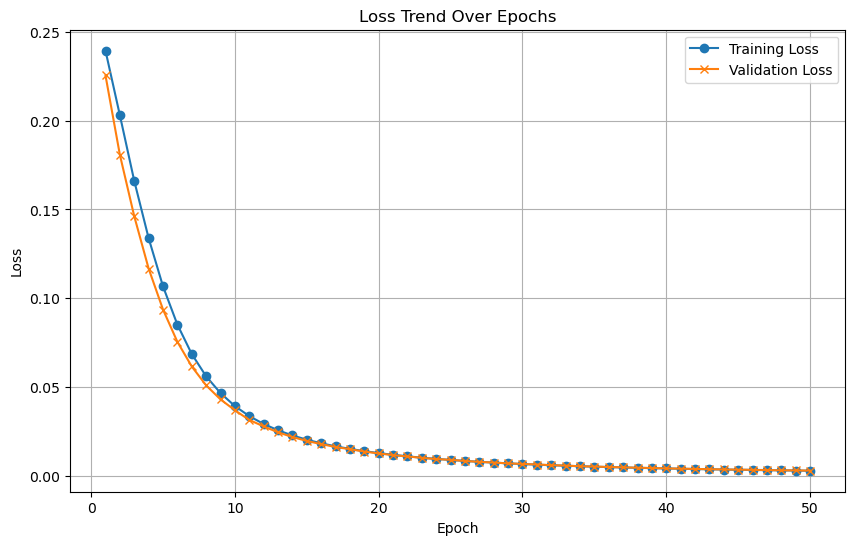

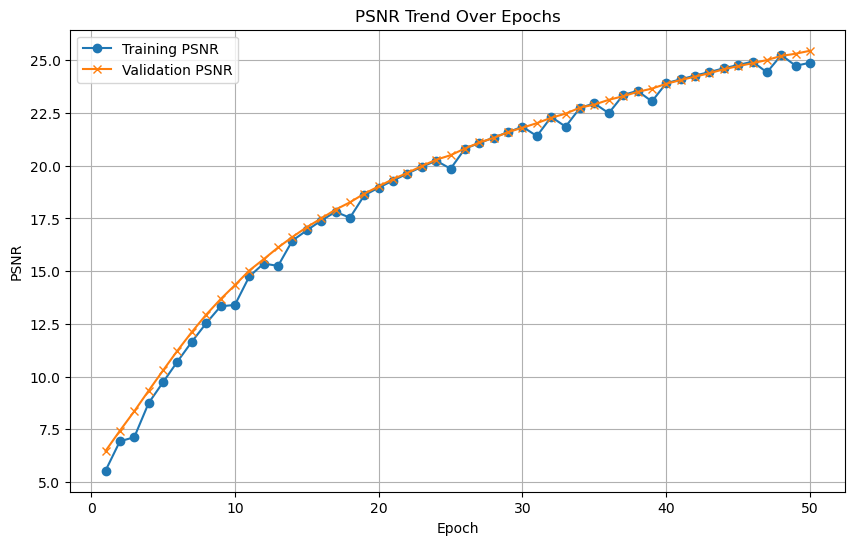

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5639
    Validation Batch [1/1], Loss: 2.5694
Validation Loss: 2.5694, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5694. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5556
    Validation Batch [1/1], Loss: 2.5694
Validation Loss: 2.5694, Validation Accuracy: 7.69%
Validation loss improved from 2.5694 to 2.5694. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5241
    Validation Batch [1/1], Loss: 2.5693
Validation Loss: 2.5693, Validation Accuracy: 7.69%
Validation loss improved from 2.5694 to 2.5693. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5244
    Validation Batch [1/1], Loss: 2.5693
Validation Loss: 2.5693, Validation Accuracy: 7.69%
Validation loss improved from 2.5693 to 2.5693. Saving model...

LOG: Epoch [5/1000] - 

    Validation Batch [1/1], Loss: 2.5690
Validation Loss: 2.5690, Validation Accuracy: 7.69%
Validation loss improved from 2.5690 to 2.5690. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4268
    Validation Batch [1/1], Loss: 2.5690
Validation Loss: 2.5690, Validation Accuracy: 7.69%
Validation loss improved from 2.5690 to 2.5690. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.4097
    Validation Batch [1/1], Loss: 2.5689
Validation Loss: 2.5689, Validation Accuracy: 7.69%
Validation loss improved from 2.5690 to 2.5689. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.4189
    Validation Batch [1/1], Loss: 2.5688
Validation Loss: 2.5688, Validation Accuracy: 7.69%
Validation loss improved from 2.5689 to 2.5688. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.3989
    Validati

    Validation Batch [1/1], Loss: 2.5642
Validation Loss: 2.5642, Validation Accuracy: 7.69%
Validation loss improved from 2.5647 to 2.5642. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 2.2692
    Validation Batch [1/1], Loss: 2.5636
Validation Loss: 2.5636, Validation Accuracy: 7.69%
Validation loss improved from 2.5642 to 2.5636. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 2.2605
    Validation Batch [1/1], Loss: 2.5628
Validation Loss: 2.5628, Validation Accuracy: 7.69%
Validation loss improved from 2.5636 to 2.5628. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 2.2614
    Validation Batch [1/1], Loss: 2.5620
Validation Loss: 2.5620, Validation Accuracy: 7.69%
Validation loss improved from 2.5628 to 2.5620. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.2536
    Validati

Epoch [77/1000] completed, Average Training Loss: 2.0851
    Validation Batch [1/1], Loss: 2.4755
Validation Loss: 2.4755, Validation Accuracy: 16.92%
Validation loss improved from 2.4824 to 2.4755. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 2.0852
    Validation Batch [1/1], Loss: 2.4669
Validation Loss: 2.4669, Validation Accuracy: 15.38%
Validation loss improved from 2.4755 to 2.4669. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 2.0507
    Validation Batch [1/1], Loss: 2.4579
Validation Loss: 2.4579, Validation Accuracy: 16.92%
Validation loss improved from 2.4669 to 2.4579. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 2.0489
    Validation Batch [1/1], Loss: 2.4498
Validation Loss: 2.4498, Validation Accuracy: 16.92%
Validation loss improved from 2.4579 to 2.4498. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [8

Epoch [105/1000] completed, Average Training Loss: 1.8160
    Validation Batch [1/1], Loss: 2.1252
Validation Loss: 2.1252, Validation Accuracy: 41.54%
Validation loss improved from 2.1339 to 2.1252. Saving model...

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 1.7994
    Validation Batch [1/1], Loss: 2.1167
Validation Loss: 2.1167, Validation Accuracy: 41.54%
Validation loss improved from 2.1252 to 2.1167. Saving model...

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 1.7841
    Validation Batch [1/1], Loss: 2.1083
Validation Loss: 2.1083, Validation Accuracy: 43.08%
Validation loss improved from 2.1167 to 2.1083. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.7846
    Validation Batch [1/1], Loss: 2.0977
Validation Loss: 2.0977, Validation Accuracy: 43.08%
Validation loss improved from 2.1083 to 2.0977. Saving model...

LOG: Epoch [109/1000] - Training


Epoch [136/1000] completed, Average Training Loss: 1.4874
    Validation Batch [1/1], Loss: 1.8845
Validation Loss: 1.8845, Validation Accuracy: 46.15%
Validation loss improved from 1.8894 to 1.8845. Saving model...

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 1.4901
    Validation Batch [1/1], Loss: 1.8731
Validation Loss: 1.8731, Validation Accuracy: 44.62%
Validation loss improved from 1.8845 to 1.8731. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 1.4794
    Validation Batch [1/1], Loss: 1.8579
Validation Loss: 1.8579, Validation Accuracy: 44.62%
Validation loss improved from 1.8731 to 1.8579. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.4478
    Validation Batch [1/1], Loss: 1.8534
Validation Loss: 1.8534, Validation Accuracy: 46.15%
Validation loss improved from 1.8579 to 1.8534. Saving model...

LOG: Epoch [140/1000] - Training


Epoch [162/1000] completed, Average Training Loss: 1.2378
    Validation Batch [1/1], Loss: 1.6797
Validation Loss: 1.6797, Validation Accuracy: 53.85%
Validation loss improved from 1.6879 to 1.6797. Saving model...

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 1.1803
    Validation Batch [1/1], Loss: 1.6752
Validation Loss: 1.6752, Validation Accuracy: 55.38%
Validation loss improved from 1.6797 to 1.6752. Saving model...

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 1.2055
    Validation Batch [1/1], Loss: 1.6710
Validation Loss: 1.6710, Validation Accuracy: 53.85%
Validation loss improved from 1.6752 to 1.6710. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 1.1571
    Validation Batch [1/1], Loss: 1.6668
Validation Loss: 1.6668, Validation Accuracy: 52.31%
Validation loss improved from 1.6710 to 1.6668. Saving model...

LOG: Epoch [166/1000] - Training


Epoch [192/1000] completed, Average Training Loss: 0.9047
    Validation Batch [1/1], Loss: 1.5017
Validation Loss: 1.5017, Validation Accuracy: 66.15%
Validation loss improved from 1.5060 to 1.5017. Saving model...

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 0.9511
    Validation Batch [1/1], Loss: 1.4817
Validation Loss: 1.4817, Validation Accuracy: 61.54%
Validation loss improved from 1.5017 to 1.4817. Saving model...

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 0.8939
    Validation Batch [1/1], Loss: 1.4919
Validation Loss: 1.4919, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [195/1000] - Training
Epoch [195/1000] completed, Average Training Loss: 0.8575
    Validation Batch [1/1], Loss: 1.5028
Validation Loss: 1.5028, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Av

Epoch [221/1000] completed, Average Training Loss: 0.6664
    Validation Batch [1/1], Loss: 1.2934
Validation Loss: 1.2934, Validation Accuracy: 73.85%
Validation loss improved from 1.3109 to 1.2934. Saving model...

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.6435
    Validation Batch [1/1], Loss: 1.2916
Validation Loss: 1.2916, Validation Accuracy: 72.31%
Validation loss improved from 1.2934 to 1.2916. Saving model...

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.6292
    Validation Batch [1/1], Loss: 1.2993
Validation Loss: 1.2993, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.6672
    Validation Batch [1/1], Loss: 1.2946
Validation Loss: 1.2946, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Av

Epoch [247/1000] completed, Average Training Loss: 0.5178
    Validation Batch [1/1], Loss: 1.3009
Validation Loss: 1.3009, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.5003
    Validation Batch [1/1], Loss: 1.2621
Validation Loss: 1.2621, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.5155
    Validation Batch [1/1], Loss: 1.1918
Validation Loss: 1.1918, Validation Accuracy: 69.23%
Validation loss improved from 1.1971 to 1.1918. Saving model...

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.4580
    Validation Batch [1/1], Loss: 1.1670
Validation Loss: 1.1670, Validation Accuracy: 69.23%
Validation loss improved from 1.1918 to 1.1670. Saving model...

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Av

    Validation Batch [1/1], Loss: 1.0620
Validation Loss: 1.0620, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.3597
    Validation Batch [1/1], Loss: 1.0793
Validation Loss: 1.0793, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.3458
    Validation Batch [1/1], Loss: 1.0451
Validation Loss: 1.0451, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.3627
    Validation Batch [1/1], Loss: 1.0381
Validation Loss: 1.0381, Validation Accuracy: 67.69%
Validation loss improved from 1.0424 to 1.0381. Saving model...

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.3224
    Validation Batch [1/1], Loss: 1.0470
Vali

    Validation Batch [1/1], Loss: 1.0914
Validation Loss: 1.0914, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.2643
    Validation Batch [1/1], Loss: 1.0677
Validation Loss: 1.0677, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.2707
    Validation Batch [1/1], Loss: 1.0470
Validation Loss: 1.0470, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.3039
    Validation Batch [1/1], Loss: 1.0643
Validation Loss: 1.0643, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.2643
    Validation Batch [1/1], Loss: 1.0637
Validation Loss

    Validation Batch [1/1], Loss: 0.9921
Validation Loss: 0.9921, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.1847
    Validation Batch [1/1], Loss: 0.9975
Validation Loss: 0.9975, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.1881
    Validation Batch [1/1], Loss: 1.0047
Validation Loss: 1.0047, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.2048
    Validation Batch [1/1], Loss: 1.0197
Validation Loss: 1.0197, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.1584
    Validation Batch [1/1], Loss: 1.0172
Validation Loss: 1.

Epoch [362/1000] completed, Average Training Loss: 0.1754
    Validation Batch [1/1], Loss: 1.0217
Validation Loss: 1.0217, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.1582
    Validation Batch [1/1], Loss: 1.0605
Validation Loss: 1.0605, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.1517
    Validation Batch [1/1], Loss: 1.1100
Validation Loss: 1.1100, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.1856
    Validation Batch [1/1], Loss: 1.0787
Validation Loss: 1.0787, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.165

Epoch [391/1000] completed, Average Training Loss: 0.1237
    Validation Batch [1/1], Loss: 0.9852
Validation Loss: 0.9852, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Average Training Loss: 0.1181
    Validation Batch [1/1], Loss: 0.9696
Validation Loss: 0.9696, Validation Accuracy: 70.77%
Validation loss improved from 0.9782 to 0.9696. Saving model...

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.1258
    Validation Batch [1/1], Loss: 0.9726
Validation Loss: 0.9726, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.1195
    Validation Batch [1/1], Loss: 0.9888
Validation Loss: 0.9888, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training

    Validation Batch [1/1], Loss: 0.9750
Validation Loss: 0.9750, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.1052
    Validation Batch [1/1], Loss: 0.9638
Validation Loss: 0.9638, Validation Accuracy: 73.85%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1098
    Validation Batch [1/1], Loss: 0.9614
Validation Loss: 0.9614, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1094
    Validation Batch [1/1], Loss: 0.9654
Validation Loss: 0.9654, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1229
    Validation Batch [1/1], Loss: 0.9730
Validation Loss: 

Epoch [453/1000] completed, Average Training Loss: 0.0846
    Validation Batch [1/1], Loss: 0.9832
Validation Loss: 0.9832, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.0862
    Validation Batch [1/1], Loss: 0.9841
Validation Loss: 0.9841, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.0906
    Validation Batch [1/1], Loss: 0.9782
Validation Loss: 0.9782, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.0830
    Validation Batch [1/1], Loss: 0.9795
Validation Loss: 0.9795, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.079

Epoch [483/1000] completed, Average Training Loss: 0.0724
    Validation Batch [1/1], Loss: 0.9864
Validation Loss: 0.9864, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.0815
    Validation Batch [1/1], Loss: 0.9661
Validation Loss: 0.9661, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.0603
    Validation Batch [1/1], Loss: 0.9712
Validation Loss: 0.9712, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.0580
    Validation Batch [1/1], Loss: 0.9756
Validation Loss: 0.9756, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.091

    Validation Batch [1/1], Loss: 1.0534
Validation Loss: 1.0534, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.0622
    Validation Batch [1/1], Loss: 1.0192
Validation Loss: 1.0192, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [513/1000] - Training
Epoch [513/1000] completed, Average Training Loss: 0.0656
    Validation Batch [1/1], Loss: 0.9859
Validation Loss: 0.9859, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.0676
    Validation Batch [1/1], Loss: 0.9878
Validation Loss: 0.9878, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 514. No improvement for 100 epochs.
Loading the best model weights...


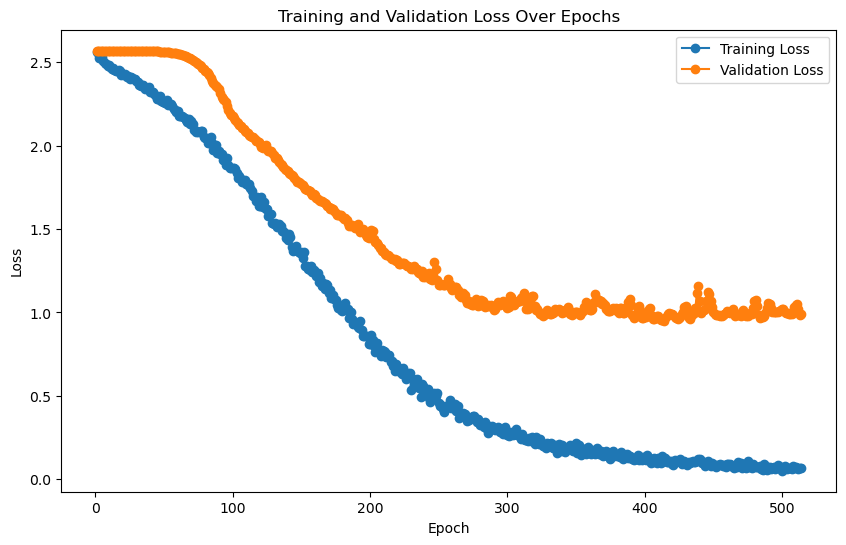

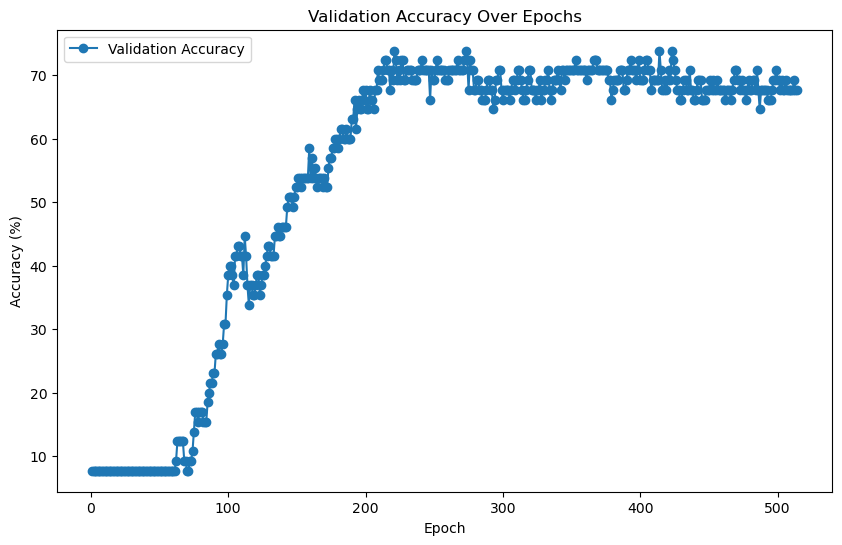


Evaluating on the test set...


    Test Batch [1/20], Loss: 0.7598

Final Test Loss: 1.1465, Test Accuracy: 72.73%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)

LOG: Training features shape: (130, 64), Training labels shape: (130,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (5016, 64), Test labels shape: (5016,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 44.62%

Validation Classification Report:
               precision    recall  f1

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)
Train reps shape: (130, 64)
Train labels shape: (130,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (5016, 64)
Test labels shape: (5016,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6577  |  Val Loss: 2.5956
Validation loss improved from inf to 2.5956.
[Epoch 2/1000] Train Loss: 2.5997  |  Val Loss: 2.5935
Validation loss improved from 2.5956 to 2.5935.
[Epoch 3/1000] Train Loss: 2.5955  |  Val Loss: 2.5929
Validation loss improved from 2.5935 to 2.5929.
[Epoch 4/1000] Train Loss: 2.5989  |  Val Loss: 2.5936
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 5/1000] Train Loss: 2.5892  |  Val Loss: 2.5706
Validation loss improved from 2.5929 to 2.5706.
[Epoch 6/1000] Train Loss: 2.5673  |  Val Loss: 2.5574
Validation loss improved from 2.5706 to 2.5574.
[Epoch 7/1000] Train Loss: 2.5506  |  Val Loss: 2.5542
Validation loss improved from 2.5574 to 2.5542.
[Epoch 8/1000] Train Loss: 2.5456  |  Val Loss: 2.5538
Validation loss improved from 2.5542 to 2.5538.
[Epoch 9/1000] Train Loss: 2.5422  |  Val Loss: 2.5534
Validation loss improved from 2.5538 to 2.5534.
[Epoch 10/1000] Train Loss: 2.5370  |  Val Loss: 2.5489
Validation los

[Epoch 24/1000] Train Loss: 2.4740  |  Val Loss: 2.5101
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 25/1000] Train Loss: 2.4785  |  Val Loss: 2.5152
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 26/1000] Train Loss: 2.4767  |  Val Loss: 2.5024
Validation loss improved from 2.5033 to 2.5024.
[Epoch 27/1000] Train Loss: 2.4628  |  Val Loss: 2.4908
Validation loss improved from 2.5024 to 2.4908.
[Epoch 28/1000] Train Loss: 2.4497  |  Val Loss: 2.4849
Validation loss improved from 2.4908 to 2.4849.


[Epoch 29/1000] Train Loss: 2.4396  |  Val Loss: 2.4824
Validation loss improved from 2.4849 to 2.4824.
[Epoch 30/1000] Train Loss: 2.4379  |  Val Loss: 2.4794
Validation loss improved from 2.4824 to 2.4794.
[Epoch 31/1000] Train Loss: 2.4310  |  Val Loss: 2.4746
Validation loss improved from 2.4794 to 2.4746.
[Epoch 32/1000] Train Loss: 2.4266  |  Val Loss: 2.4747
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 33/1000] Train Loss: 2.4251  |  Val Loss: 2.4776
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 34/1000] Train Loss: 2.4304  |  Val Loss: 2.4806
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 35/1000] Train Loss: 2.4324  |  Val Loss: 2.4815
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 36/1000] Train Loss: 2.4328  |  Val Loss: 2.4850
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 37/1000] Train Loss: 2.4355  |  Val Loss: 2.4960
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 38/1000] Train Loss: 

[Epoch 53/1000] Train Loss: 2.3811  |  Val Loss: 2.4689
Validation loss improved from 2.4701 to 2.4689.
[Epoch 54/1000] Train Loss: 2.3797  |  Val Loss: 2.4743
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 2.3816  |  Val Loss: 2.4727
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 56/1000] Train Loss: 2.3776  |  Val Loss: 2.4662
Validation loss improved from 2.4689 to 2.4662.
[Epoch 57/1000] Train Loss: 2.3698  |  Val Loss: 2.4588
Validation loss improved from 2.4662 to 2.4588.


[Epoch 58/1000] Train Loss: 2.3653  |  Val Loss: 2.4607
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 59/1000] Train Loss: 2.3689  |  Val Loss: 2.4638
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 60/1000] Train Loss: 2.3692  |  Val Loss: 2.4676
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 61/1000] Train Loss: 2.3727  |  Val Loss: 2.4661
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 62/1000] Train Loss: 2.3651  |  Val Loss: 2.4599
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 63/1000] Train Loss: 2.3596  |  Val Loss: 2.4570
Validation loss improved from 2.4588 to 2.4570.
[Epoch 64/1000] Train Loss: 2.3600  |  Val Loss: 2.4530
Validation loss improved from 2.4570 to 2.4530.
[Epoch 65/1000] Train Loss: 2.3495  |  Val Loss: 2.4500
Validation loss improved from 2.4530 to 2.4500.
[Epoch 66/1000] Train Loss: 2.3466  |  Val Loss: 2.4644
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 67/1000] Train Loss: 

[Epoch 83/1000] Train Loss: 2.3239  |  Val Loss: 2.4468
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 84/1000] Train Loss: 2.3145  |  Val Loss: 2.4469
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 85/1000] Train Loss: 2.3151  |  Val Loss: 2.4494
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 86/1000] Train Loss: 2.3183  |  Val Loss: 2.4596
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 87/1000] Train Loss: 2.3290  |  Val Loss: 2.4659
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 88/1000] Train Loss: 2.3322  |  Val Loss: 2.4700
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 89/1000] Train Loss: 2.3354  |  Val Loss: 2.4791
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 90/1000] Train Loss: 2.3401  |  Val Loss: 2.4798
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 91/1000] Train Loss: 2.3400  |  Val Loss: 2.4865
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 92/1000] Train Loss: 2.3428  |  Val Loss: 2.4888
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 93/1000] Train Loss: 2.3399  |  Val Loss: 2.4937
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 94/1000] Train Loss: 2.3410  |  Val Loss: 2.4887
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 95/1000] Train Loss: 2.3344  |  Val Loss: 2.4892
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 96/1000] Train Loss: 2.3348  |  Val Loss: 2.4853
!! Validation loss did NOT improve !! Patience: 19/100
[

[Epoch 112/1000] Train Loss: 2.3536  |  Val Loss: 2.4514
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 113/1000] Train Loss: 2.3314  |  Val Loss: 2.4326
Validation loss improved from 2.4366 to 2.4326.
[Epoch 114/1000] Train Loss: 2.2989  |  Val Loss: 2.4272
Validation loss improved from 2.4326 to 2.4272.
[Epoch 115/1000] Train Loss: 2.2723  |  Val Loss: 2.4493
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 2.2745  |  Val Loss: 2.4689
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 117/1000] Train Loss: 2.2800  |  Val Loss: 2.4883
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 118/1000] Train Loss: 2.2959  |  Val Loss: 2.5102
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 119/1000] Train Loss: 2.3162  |  Val Loss: 2.5051
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 120/1000] Train Loss: 2.3135  |  Val Loss: 2.4687
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 121/1

[Epoch 143/1000] Train Loss: 2.2226  |  Val Loss: 2.4111
Validation loss improved from 2.4111 to 2.4111.
[Epoch 144/1000] Train Loss: 2.2171  |  Val Loss: 2.4125
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 145/1000] Train Loss: 2.2127  |  Val Loss: 2.4209
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 146/1000] Train Loss: 2.2164  |  Val Loss: 2.4276
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 147/1000] Train Loss: 2.2192  |  Val Loss: 2.4280
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 148/1000] Train Loss: 2.2118  |  Val Loss: 2.4442
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 149/1000] Train Loss: 2.2252  |  Val Loss: 2.4710
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 150/1000] Train Loss: 2.2656  |  Val Loss: 2.4769
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 151/1000] Train Loss: 2.2514  |  Val Loss: 2.4380
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 174/1000] Train Loss: 2.2031  |  Val Loss: 2.3997
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 175/1000] Train Loss: 2.1681  |  Val Loss: 2.3774
Validation loss improved from 2.3944 to 2.3774.
[Epoch 176/1000] Train Loss: 2.1519  |  Val Loss: 2.3984
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 177/1000] Train Loss: 2.1779  |  Val Loss: 2.4193
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 178/1000] Train Loss: 2.1855  |  Val Loss: 2.4021
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 179/1000] Train Loss: 2.1605  |  Val Loss: 2.3921
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 180/1000] Train Loss: 2.1456  |  Val Loss: 2.4239
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 181/1000] Train Loss: 2.1757  |  Val Loss: 2.4565
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 182/1000] Train Loss: 2.1706  |  Val Loss: 2.4369
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 

[Epoch 204/1000] Train Loss: 2.1886  |  Val Loss: 2.3610
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 205/1000] Train Loss: 2.1449  |  Val Loss: 2.4386
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 206/1000] Train Loss: 2.2024  |  Val Loss: 2.3959
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 207/1000] Train Loss: 2.1342  |  Val Loss: 2.3297
Validation loss improved from 2.3441 to 2.3297.
[Epoch 208/1000] Train Loss: 2.0893  |  Val Loss: 2.3736
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 209/1000] Train Loss: 2.1130  |  Val Loss: 2.3399
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 210/1000] Train Loss: 2.0596  |  Val Loss: 2.3478
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 211/1000] Train Loss: 2.0923  |  Val Loss: 2.3745
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 212/1000] Train Loss: 2.1025  |  Val Loss: 2.3303
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 234/1000] Train Loss: 2.1175  |  Val Loss: 2.3763
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 235/1000] Train Loss: 2.0958  |  Val Loss: 2.3001
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 236/1000] Train Loss: 1.9981  |  Val Loss: 2.3202
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 237/1000] Train Loss: 2.0057  |  Val Loss: 2.3048
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 238/1000] Train Loss: 1.9855  |  Val Loss: 2.2854
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 239/1000] Train Loss: 1.9774  |  Val Loss: 2.2955
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 240/1000] Train Loss: 1.9758  |  Val Loss: 2.3122
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 241/1000] Train Loss: 1.9841  |  Val Loss: 2.3263
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 242/1000] Train Loss: 1.9951  |  Val Loss: 2.3132
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 267/1000] Train Loss: 1.8979  |  Val Loss: 2.2432
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 268/1000] Train Loss: 1.9054  |  Val Loss: 2.2367
Validation loss improved from 2.2385 to 2.2367.
[Epoch 269/1000] Train Loss: 1.9010  |  Val Loss: 2.2629
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 270/1000] Train Loss: 1.9170  |  Val Loss: 2.2580
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 271/1000] Train Loss: 1.9084  |  Val Loss: 2.2261
Validation loss improved from 2.2367 to 2.2261.
[Epoch 272/1000] Train Loss: 1.8818  |  Val Loss: 2.2320
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 273/1000] Train Loss: 1.9061  |  Val Loss: 2.2430
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 274/1000] Train Loss: 1.9246  |  Val Loss: 2.2399
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 275/1000] Train Loss: 1.9084  |  Val Loss: 2.2529
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 276/10

[Epoch 297/1000] Train Loss: 1.9078  |  Val Loss: 2.2865
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 298/1000] Train Loss: 1.8637  |  Val Loss: 2.2200
Validation loss improved from 2.2261 to 2.2200.
[Epoch 299/1000] Train Loss: 1.8754  |  Val Loss: 2.2695
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 300/1000] Train Loss: 1.9133  |  Val Loss: 2.2169
Validation loss improved from 2.2200 to 2.2169.
[Epoch 301/1000] Train Loss: 1.8467  |  Val Loss: 2.2702
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 302/1000] Train Loss: 1.8815  |  Val Loss: 2.2677
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 303/1000] Train Loss: 1.8571  |  Val Loss: 2.2170
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 304/1000] Train Loss: 1.8461  |  Val Loss: 2.2228
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 305/1000] Train Loss: 1.8277  |  Val Loss: 2.3866
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 306/1

[Epoch 326/1000] Train Loss: 1.8251  |  Val Loss: 2.2437
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 327/1000] Train Loss: 1.8125  |  Val Loss: 2.2877
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 328/1000] Train Loss: 1.8182  |  Val Loss: 2.3420
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 329/1000] Train Loss: 1.8599  |  Val Loss: 2.3620
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 330/1000] Train Loss: 1.8544  |  Val Loss: 2.3120
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 331/1000] Train Loss: 1.8085  |  Val Loss: 2.3125
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 332/1000] Train Loss: 1.8223  |  Val Loss: 2.3633
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 333/1000] Train Loss: 1.9181  |  Val Loss: 2.2434
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 334/1000] Train Loss: 1.8212  |  Val Loss: 2.2437
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 356/1000] Train Loss: 1.8250  |  Val Loss: 2.2061
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 357/1000] Train Loss: 1.7960  |  Val Loss: 2.1805
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 358/1000] Train Loss: 1.7905  |  Val Loss: 2.1733
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 359/1000] Train Loss: 1.7861  |  Val Loss: 2.1493
Validation loss improved from 2.1675 to 2.1493.
[Epoch 360/1000] Train Loss: 1.8011  |  Val Loss: 2.1737
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 361/1000] Train Loss: 1.8510  |  Val Loss: 2.1610
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 362/1000] Train Loss: 1.8272  |  Val Loss: 2.1203
Validation loss improved from 2.1493 to 2.1203.
[Epoch 363/1000] Train Loss: 1.7756  |  Val Loss: 2.1716
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 364/1000] Train Loss: 1.8042  |  Val Loss: 2.1603
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 365

[Epoch 384/1000] Train Loss: 1.8213  |  Val Loss: 2.1692
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 385/1000] Train Loss: 1.7594  |  Val Loss: 2.2189
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 386/1000] Train Loss: 1.8096  |  Val Loss: 2.2695
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 387/1000] Train Loss: 1.8176  |  Val Loss: 2.1520
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 388/1000] Train Loss: 1.7322  |  Val Loss: 2.1970
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 389/1000] Train Loss: 1.8387  |  Val Loss: 2.2276
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 390/1000] Train Loss: 1.8461  |  Val Loss: 2.1577
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 391/1000] Train Loss: 1.7498  |  Val Loss: 2.2010
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 392/1000] Train Loss: 1.7581  |  Val Loss: 2.1662
!! Validation loss did NOT improve !! Patience:

[Epoch 413/1000] Train Loss: 1.7645  |  Val Loss: 2.2786
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 414/1000] Train Loss: 1.8503  |  Val Loss: 2.2051
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 415/1000] Train Loss: 1.7456  |  Val Loss: 2.2475
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 416/1000] Train Loss: 1.7982  |  Val Loss: 2.2710
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 417/1000] Train Loss: 1.7750  |  Val Loss: 2.1674
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 418/1000] Train Loss: 1.7093  |  Val Loss: 2.1651
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 419/1000] Train Loss: 1.7076  |  Val Loss: 2.1814
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 420/1000] Train Loss: 1.7140  |  Val Loss: 2.1877
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 421/1000] Train Loss: 1.7125  |  Val Loss: 2.1948
!! Validation loss did NOT improve !! Patience:

[Epoch 446/1000] Train Loss: 1.6975  |  Val Loss: 2.2297
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 447/1000] Train Loss: 1.7433  |  Val Loss: 2.2279
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 448/1000] Train Loss: 1.6967  |  Val Loss: 2.2181
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 449/1000] Train Loss: 1.7169  |  Val Loss: 2.2068
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 450/1000] Train Loss: 1.7102  |  Val Loss: 2.2008
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 451/1000] Train Loss: 1.7220  |  Val Loss: 2.2056
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 452/1000] Train Loss: 1.7260  |  Val Loss: 2.1891
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 453/1000] Train Loss: 1.7036  |  Val Loss: 2.2425
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 454/1000] Train Loss: 1.7399  |  Val Loss: 2.1614
!! Validation loss did NOT improve !! Patience:

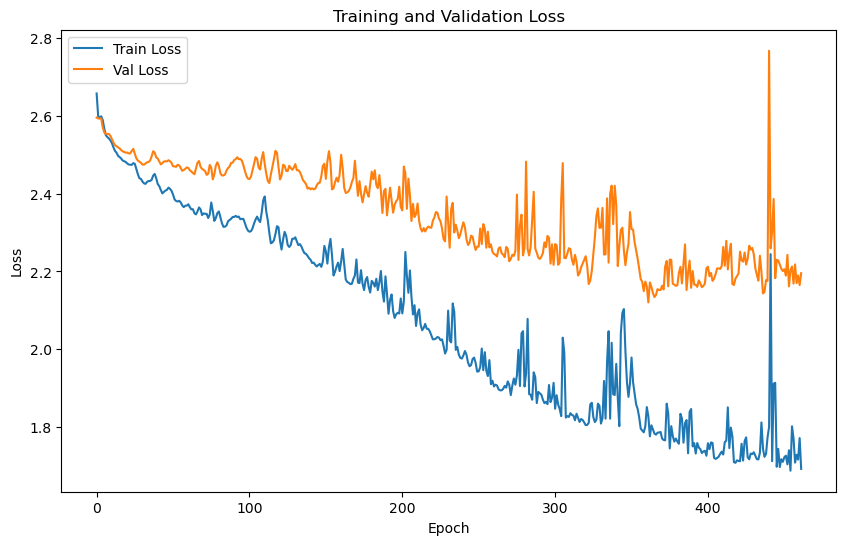

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.9793 | Test Accuracy: 40.29%


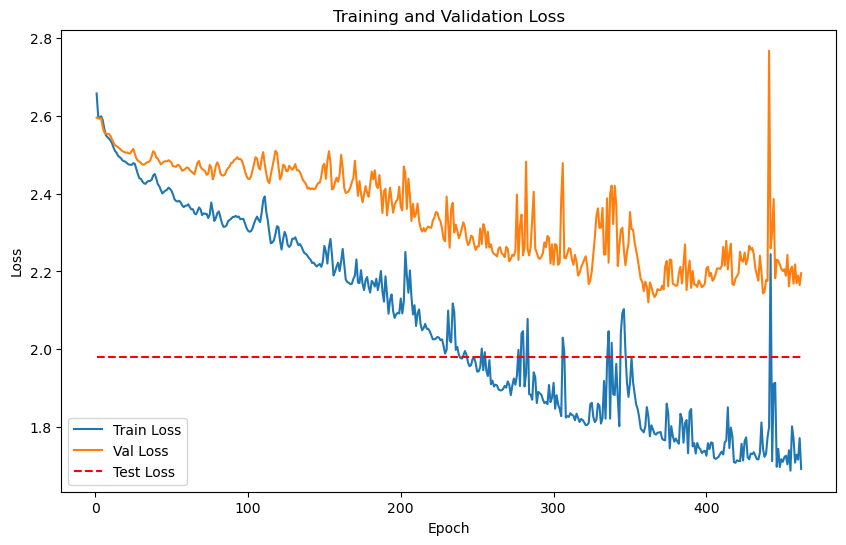

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)


Train embeddings shape: (130, 64), 
Train labels shape: (130,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5016, 64), 
Test labels shape: (5016,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}
Training batch size: 130


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.5584
Epoch [1/2000], Avg Train Loss: 8.5584
Epoch [1/2000], Avg Val Loss: 5.3787
Validation loss improved from inf to 5.3787. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.6259
Epoch [2/2000], Avg Train Loss: 8.6259
Epoch [2/2000], Avg Val Loss: 5.3479
Validation loss improved from 5.3787 to 5.3479. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.6008
Epoch [3/2000], Avg Train Loss: 8.6008
Epoch [3/2000], Avg Val Loss: 5.3177
Validation loss improved from 5.3479 to 5.3177. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.4160
Epoch [4/2000], Avg Train Loss: 8.4160
Epoch [4/2000], Avg Val Loss: 5.2877
Validation loss improved from 5.3177 to 5.2877. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.3429
Epoch [5/2000], Avg Train Loss: 8.3429
Epoch [5/2000], Avg Val Loss: 5.2583
Validation loss improved from 5.2877 to 5.2583. Saving mode

    Batch [1/1], Train Loss: 7.3702
Epoch [19/2000], Avg Train Loss: 7.3702
Epoch [19/2000], Avg Val Loss: 4.8806
Validation loss improved from 4.9056 to 4.8806. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.1216
Epoch [20/2000], Avg Train Loss: 7.1216
Epoch [20/2000], Avg Val Loss: 4.8558
Validation loss improved from 4.8806 to 4.8558. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.9611
Epoch [21/2000], Avg Train Loss: 6.9611
Epoch [21/2000], Avg Val Loss: 4.8313
Validation loss improved from 4.8558 to 4.8313. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 7.1810
Epoch [22/2000], Avg Train Loss: 7.1810
Epoch [22/2000], Avg Val Loss: 4.8073
Validation loss improved from 4.8313 to 4.8073. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.9699
Epoch [23/2000], Avg Train Loss: 6.9699
Epoch [23/2000], Avg Val Loss: 4.7835
Validation loss improved from 4.8073 to 4.

Epoch [31/2000], Avg Val Loss: 4.6064
Validation loss improved from 4.6272 to 4.6064. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.6051
Epoch [32/2000], Avg Train Loss: 6.6051
Epoch [32/2000], Avg Val Loss: 4.5860
Validation loss improved from 4.6064 to 4.5860. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.5687
Epoch [33/2000], Avg Train Loss: 6.5687
Epoch [33/2000], Avg Val Loss: 4.5660
Validation loss improved from 4.5860 to 4.5660. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.4473
Epoch [34/2000], Avg Train Loss: 6.4473
Epoch [34/2000], Avg Val Loss: 4.5463
Validation loss improved from 4.5660 to 4.5463. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 6.5823
Epoch [35/2000], Avg Train Loss: 6.5823
Epoch [35/2000], Avg Val Loss: 4.5271
Validation loss improved from 4.5463 to 4.5271. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.0015
Epoch [48/2000], Avg Train Loss: 6.0015
Epoch [48/2000], Avg Val Loss: 4.3109
Validation loss improved from 4.3255 to 4.3109. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.8752
Epoch [49/2000], Avg Train Loss: 5.8752
Epoch [49/2000], Avg Val Loss: 4.2967
Validation loss improved from 4.3109 to 4.2967. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 6.0964
Epoch [50/2000], Avg Train Loss: 6.0964
Epoch [50/2000], Avg Val Loss: 4.2828
Validation loss improved from 4.2967 to 4.2828. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.9268
Epoch [51/2000], Avg Train Loss: 5.9268
Epoch [51/2000], Avg Val Loss: 4.2692
Validation loss improved from 4.2828 to 4.2692. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.9243
Epoch [52/2000], Avg Train Loss: 5.9243
Epoch [52/2000], Avg Val Loss: 4.2559
Validation loss improved from 4.2692 to 4.

    Batch [1/1], Train Loss: 5.4741
Epoch [66/2000], Avg Train Loss: 5.4741
Epoch [66/2000], Avg Val Loss: 4.1041
Validation loss improved from 4.1130 to 4.1041. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 5.5269
Epoch [67/2000], Avg Train Loss: 5.5269
Epoch [67/2000], Avg Val Loss: 4.0955
Validation loss improved from 4.1041 to 4.0955. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 5.4721
Epoch [68/2000], Avg Train Loss: 5.4721
Epoch [68/2000], Avg Val Loss: 4.0871
Validation loss improved from 4.0955 to 4.0871. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 5.4310
Epoch [69/2000], Avg Train Loss: 5.4310
Epoch [69/2000], Avg Val Loss: 4.0789
Validation loss improved from 4.0871 to 4.0789. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.4707
Epoch [70/2000], Avg Train Loss: 5.4707
Epoch [70/2000], Avg Val Loss: 4.0709
Validation loss improved from 4.0789 to 4.

    Batch [1/1], Train Loss: 5.3895
Epoch [79/2000], Avg Train Loss: 5.3895
Epoch [79/2000], Avg Val Loss: 4.0089
Validation loss improved from 4.0150 to 4.0089. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 5.3264
Epoch [80/2000], Avg Train Loss: 5.3264
Epoch [80/2000], Avg Val Loss: 4.0030
Validation loss improved from 4.0089 to 4.0030. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 5.3127
Epoch [81/2000], Avg Train Loss: 5.3127
Epoch [81/2000], Avg Val Loss: 3.9973
Validation loss improved from 4.0030 to 3.9973. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 5.3034
Epoch [82/2000], Avg Train Loss: 5.3034
Epoch [82/2000], Avg Val Loss: 3.9919
Validation loss improved from 3.9973 to 3.9919. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 5.2608
Epoch [83/2000], Avg Train Loss: 5.2608
Epoch [83/2000], Avg Val Loss: 3.9866
Validation loss improved from 3.9919 to 3.

Epoch [95/2000], Avg Val Loss: 3.9341
Validation loss improved from 3.9379 to 3.9341. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.1479
Epoch [96/2000], Avg Train Loss: 5.1479
Epoch [96/2000], Avg Val Loss: 3.9304
Validation loss improved from 3.9341 to 3.9304. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 5.1354
Epoch [97/2000], Avg Train Loss: 5.1354
Epoch [97/2000], Avg Val Loss: 3.9268
Validation loss improved from 3.9304 to 3.9268. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 5.2089
Epoch [98/2000], Avg Train Loss: 5.2089
Epoch [98/2000], Avg Val Loss: 3.9234
Validation loss improved from 3.9268 to 3.9234. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 5.1244
Epoch [99/2000], Avg Train Loss: 5.1244
Epoch [99/2000], Avg Val Loss: 3.9200
Validation loss improved from 3.9234 to 3.9200. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Tra

    Batch [1/1], Train Loss: 5.0673
Epoch [114/2000], Avg Train Loss: 5.0673
Epoch [114/2000], Avg Val Loss: 3.8772
Validation loss improved from 3.8797 to 3.8772. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.9649
Epoch [115/2000], Avg Train Loss: 4.9649
Epoch [115/2000], Avg Val Loss: 3.8748
Validation loss improved from 3.8772 to 3.8748. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 5.0399
Epoch [116/2000], Avg Train Loss: 5.0399
Epoch [116/2000], Avg Val Loss: 3.8724
Validation loss improved from 3.8748 to 3.8724. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.9988
Epoch [117/2000], Avg Train Loss: 4.9988
Epoch [117/2000], Avg Val Loss: 3.8701
Validation loss improved from 3.8724 to 3.8701. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.9430
Epoch [118/2000], Avg Train Loss: 4.9430
Epoch [118/2000], Avg Val Loss: 3.8678
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9341
Epoch [124/2000], Avg Train Loss: 4.9341
Epoch [124/2000], Avg Val Loss: 3.8550
Validation loss improved from 3.8571 to 3.8550. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 4.8233
Epoch [125/2000], Avg Train Loss: 4.8233
Epoch [125/2000], Avg Val Loss: 3.8530
Validation loss improved from 3.8550 to 3.8530. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 4.9308
Epoch [126/2000], Avg Train Loss: 4.9308
Epoch [126/2000], Avg Val Loss: 3.8511
Validation loss improved from 3.8530 to 3.8511. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.8424
Epoch [127/2000], Avg Train Loss: 4.8424
Epoch [127/2000], Avg Val Loss: 3.8492
Validation loss improved from 3.8511 to 3.8492. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.9496
Epoch [128/2000], Avg Train Loss: 4.9496
Epoch [128/2000], Avg Val Loss: 3.8473
Validation loss improved fro

Epoch [137/2000], Avg Val Loss: 3.8324
Validation loss improved from 3.8339 to 3.8324. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 4.7835
Epoch [138/2000], Avg Train Loss: 4.7835
Epoch [138/2000], Avg Val Loss: 3.8310
Validation loss improved from 3.8324 to 3.8310. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 4.8358
Epoch [139/2000], Avg Train Loss: 4.8358
Epoch [139/2000], Avg Val Loss: 3.8296
Validation loss improved from 3.8310 to 3.8296. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 4.8701
Epoch [140/2000], Avg Train Loss: 4.8701
Epoch [140/2000], Avg Val Loss: 3.8282
Validation loss improved from 3.8296 to 3.8282. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 4.9421
Epoch [141/2000], Avg Train Loss: 4.9421
Epoch [141/2000], Avg Val Loss: 3.8269
Validation loss improved from 3.8282 to 3.8269. Saving model...

LOG: Epoch [142/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7424
Epoch [155/2000], Avg Train Loss: 4.7424
Epoch [155/2000], Avg Val Loss: 3.8106
Validation loss improved from 3.8117 to 3.8106. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.8060
Epoch [156/2000], Avg Train Loss: 4.8060
Epoch [156/2000], Avg Val Loss: 3.8096
Validation loss improved from 3.8106 to 3.8096. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.8274
Epoch [157/2000], Avg Train Loss: 4.8274
Epoch [157/2000], Avg Val Loss: 3.8087
Validation loss improved from 3.8096 to 3.8087. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.8107
Epoch [158/2000], Avg Train Loss: 4.8107
Epoch [158/2000], Avg Val Loss: 3.8078
Validation loss improved from 3.8087 to 3.8078. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.7994
Epoch [159/2000], Avg Train Loss: 4.7994
Epoch [159/2000], Avg Val Loss: 3.8069
Validation loss improved fro

Epoch [167/2000], Avg Val Loss: 3.8005
Validation loss improved from 3.8012 to 3.8005. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 4.7337
Epoch [168/2000], Avg Train Loss: 4.7337
Epoch [168/2000], Avg Val Loss: 3.7998
Validation loss improved from 3.8005 to 3.7998. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 4.7612
Epoch [169/2000], Avg Train Loss: 4.7612
Epoch [169/2000], Avg Val Loss: 3.7991
Validation loss improved from 3.7998 to 3.7991. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 4.7418
Epoch [170/2000], Avg Train Loss: 4.7418
Epoch [170/2000], Avg Val Loss: 3.7984
Validation loss improved from 3.7991 to 3.7984. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 4.7397
Epoch [171/2000], Avg Train Loss: 4.7397
Epoch [171/2000], Avg Val Loss: 3.7978
Validation loss improved from 3.7984 to 3.7978. Saving model...

LOG: Epoch [172/2000] - Training
    Bat

Epoch [178/2000], Avg Val Loss: 3.7937
Validation loss improved from 3.7942 to 3.7937. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 4.7424
Epoch [179/2000], Avg Train Loss: 4.7424
Epoch [179/2000], Avg Val Loss: 3.7932
Validation loss improved from 3.7937 to 3.7932. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 4.6932
Epoch [180/2000], Avg Train Loss: 4.6932
Epoch [180/2000], Avg Val Loss: 3.7926
Validation loss improved from 3.7932 to 3.7926. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 4.7249
Epoch [181/2000], Avg Train Loss: 4.7249
Epoch [181/2000], Avg Val Loss: 3.7922
Validation loss improved from 3.7926 to 3.7922. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 4.6859
Epoch [182/2000], Avg Train Loss: 4.6859
Epoch [182/2000], Avg Val Loss: 3.7917
Validation loss improved from 3.7922 to 3.7917. Saving model...

LOG: Epoch [183/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6625
Epoch [196/2000], Avg Train Loss: 4.6625
Epoch [196/2000], Avg Val Loss: 3.7865
Validation loss improved from 3.7867 to 3.7865. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 4.6698
Epoch [197/2000], Avg Train Loss: 4.6698
Epoch [197/2000], Avg Val Loss: 3.7862
Validation loss improved from 3.7865 to 3.7862. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 4.6564
Epoch [198/2000], Avg Train Loss: 4.6564
Epoch [198/2000], Avg Val Loss: 3.7860
Validation loss improved from 3.7862 to 3.7860. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 4.6184
Epoch [199/2000], Avg Train Loss: 4.6184
Epoch [199/2000], Avg Val Loss: 3.7858
Validation loss improved from 3.7860 to 3.7858. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 4.6824
Epoch [200/2000], Avg Train Loss: 4.6824
Epoch [200/2000], Avg Val Loss: 3.7855
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6283
Epoch [214/2000], Avg Train Loss: 4.6283
Epoch [214/2000], Avg Val Loss: 3.7825
Validation loss improved from 3.7827 to 3.7825. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 4.6404
Epoch [215/2000], Avg Train Loss: 4.6404
Epoch [215/2000], Avg Val Loss: 3.7824
Validation loss improved from 3.7825 to 3.7824. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 4.6541
Epoch [216/2000], Avg Train Loss: 4.6541
Epoch [216/2000], Avg Val Loss: 3.7822
Validation loss improved from 3.7824 to 3.7822. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 4.6302
Epoch [217/2000], Avg Train Loss: 4.6302
Epoch [217/2000], Avg Val Loss: 3.7820
Validation loss improved from 3.7822 to 3.7820. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 4.6307
Epoch [218/2000], Avg Train Loss: 4.6307
Epoch [218/2000], Avg Val Loss: 3.7818
Validation loss improved fro

Epoch [226/2000], Avg Val Loss: 3.7802
Validation loss improved from 3.7803 to 3.7802. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 4.6114
Epoch [227/2000], Avg Train Loss: 4.6114
Epoch [227/2000], Avg Val Loss: 3.7801
Validation loss improved from 3.7802 to 3.7801. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 4.6232
Epoch [228/2000], Avg Train Loss: 4.6232
Epoch [228/2000], Avg Val Loss: 3.7800
Validation loss improved from 3.7801 to 3.7800. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 4.6426
Epoch [229/2000], Avg Train Loss: 4.6426
Epoch [229/2000], Avg Val Loss: 3.7799
Validation loss improved from 3.7800 to 3.7799. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 4.5368
Epoch [230/2000], Avg Train Loss: 4.5368
Epoch [230/2000], Avg Val Loss: 3.7797
Validation loss improved from 3.7799 to 3.7797. Saving model...

LOG: Epoch [231/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5729
Epoch [241/2000], Avg Train Loss: 4.5729
Epoch [241/2000], Avg Val Loss: 3.7796
Validation loss did not improve. Patience: 7/100

LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 4.5761
Epoch [242/2000], Avg Train Loss: 4.5761
Epoch [242/2000], Avg Val Loss: 3.7795
Validation loss did not improve. Patience: 8/100

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 4.6218
Epoch [243/2000], Avg Train Loss: 4.6218
Epoch [243/2000], Avg Val Loss: 3.7794
Validation loss improved from 3.7794 to 3.7794. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 4.5292
Epoch [244/2000], Avg Train Loss: 4.5292
Epoch [244/2000], Avg Val Loss: 3.7794
Validation loss improved from 3.7794 to 3.7794. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 4.5697
Epoch [245/2000], Avg Train Loss: 4.5697
Epoch [245/2000], Avg Val Loss: 3.7793
Validation loss improved from 3.7794 to 3.7793. Saving mod

Epoch [260/2000], Avg Val Loss: 3.7775
Validation loss improved from 3.7776 to 3.7775. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 4.5709
Epoch [261/2000], Avg Train Loss: 4.5709
Epoch [261/2000], Avg Val Loss: 3.7774
Validation loss improved from 3.7775 to 3.7774. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.5672
Epoch [262/2000], Avg Train Loss: 4.5672
Epoch [262/2000], Avg Val Loss: 3.7774
Validation loss improved from 3.7774 to 3.7774. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 4.5594
Epoch [263/2000], Avg Train Loss: 4.5594
Epoch [263/2000], Avg Val Loss: 3.7773
Validation loss improved from 3.7774 to 3.7773. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 4.6074
Epoch [264/2000], Avg Train Loss: 4.6074
Epoch [264/2000], Avg Val Loss: 3.7773
Validation loss improved from 3.7773 to 3.7773. Saving model...

LOG: Epoch [265/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5073
Epoch [272/2000], Avg Train Loss: 4.5073
Epoch [272/2000], Avg Val Loss: 3.7775
Validation loss did not improve. Patience: 6/100

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 4.5468
Epoch [273/2000], Avg Train Loss: 4.5468
Epoch [273/2000], Avg Val Loss: 3.7775
Validation loss did not improve. Patience: 7/100

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 4.5432
Epoch [274/2000], Avg Train Loss: 4.5432
Epoch [274/2000], Avg Val Loss: 3.7774
Validation loss did not improve. Patience: 8/100

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 4.5295
Epoch [275/2000], Avg Train Loss: 4.5295
Epoch [275/2000], Avg Val Loss: 3.7774
Validation loss did not improve. Patience: 9/100

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 4.5673
Epoch [276/2000], Avg Train Loss: 4.5673
Epoch [276/2000], Avg Val Loss: 3.7773
Validation loss did not improve. Patience: 10/100

LOG: Epoch [277/2000] - Training
    

Epoch [284/2000], Avg Val Loss: 3.7767
Validation loss improved from 3.7768 to 3.7767. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 4.5120
Epoch [285/2000], Avg Train Loss: 4.5120
Epoch [285/2000], Avg Val Loss: 3.7767
Validation loss did not improve. Patience: 1/100

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 4.5258
Epoch [286/2000], Avg Train Loss: 4.5258
Epoch [286/2000], Avg Val Loss: 3.7768
Validation loss did not improve. Patience: 2/100

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 4.5059
Epoch [287/2000], Avg Train Loss: 4.5059
Epoch [287/2000], Avg Val Loss: 3.7769
Validation loss did not improve. Patience: 3/100

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 4.5404
Epoch [288/2000], Avg Train Loss: 4.5404
Epoch [288/2000], Avg Val Loss: 3.7770
Validation loss did not improve. Patience: 4/100

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 4.5172
Epoch [289/2000], Avg Train Los

    Batch [1/1], Train Loss: 4.4324
Epoch [306/2000], Avg Train Loss: 4.4324
Epoch [306/2000], Avg Val Loss: 3.7787
Validation loss did not improve. Patience: 22/100

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 4.4813
Epoch [307/2000], Avg Train Loss: 4.4813
Epoch [307/2000], Avg Val Loss: 3.7789
Validation loss did not improve. Patience: 23/100

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 4.4435
Epoch [308/2000], Avg Train Loss: 4.4435
Epoch [308/2000], Avg Val Loss: 3.7791
Validation loss did not improve. Patience: 24/100

LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 4.4689
Epoch [309/2000], Avg Train Loss: 4.4689
Epoch [309/2000], Avg Val Loss: 3.7793
Validation loss did not improve. Patience: 25/100

LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 4.4799
Epoch [310/2000], Avg Train Loss: 4.4799
Epoch [310/2000], Avg Val Loss: 3.7794
Validation loss did not improve. Patience: 26/100

LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 4.4668
Epoch [317/2000], Avg Train Loss: 4.4668
Epoch [317/2000], Avg Val Loss: 3.7796
Validation loss did not improve. Patience: 33/100

LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 4.5080
Epoch [318/2000], Avg Train Loss: 4.5080
Epoch [318/2000], Avg Val Loss: 3.7795
Validation loss did not improve. Patience: 34/100

LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 4.5412
Epoch [319/2000], Avg Train Loss: 4.5412
Epoch [319/2000], Avg Val Loss: 3.7794
Validation loss did not improve. Patience: 35/100

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 4.4700
Epoch [320/2000], Avg Train Loss: 4.4700
Epoch [320/2000], Avg Val Loss: 3.7792
Validation loss did not improve. Patience: 36/100

LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 4.4520
Epoch [321/2000], Avg Train Loss: 4.4520
Epoch [321/2000], Avg Val Loss: 3.7791
Validation loss did not improve. Patience: 37/100

LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 4.4779
Epoch [328/2000], Avg Train Loss: 4.4779
Epoch [328/2000], Avg Val Loss: 3.7777
Validation loss did not improve. Patience: 44/100

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 4.5003
Epoch [329/2000], Avg Train Loss: 4.5003
Epoch [329/2000], Avg Val Loss: 3.7775
Validation loss did not improve. Patience: 45/100

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 4.5199
Epoch [330/2000], Avg Train Loss: 4.5199
Epoch [330/2000], Avg Val Loss: 3.7772
Validation loss did not improve. Patience: 46/100

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 4.4200
Epoch [331/2000], Avg Train Loss: 4.4200
Epoch [331/2000], Avg Val Loss: 3.7770
Validation loss did not improve. Patience: 47/100

LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 4.4633
Epoch [332/2000], Avg Train Loss: 4.4633
Epoch [332/2000], Avg Val Loss: 3.7767
Validation loss did not improve. Patience: 48/100

LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 4.4076
Epoch [349/2000], Avg Train Loss: 4.4076
Epoch [349/2000], Avg Val Loss: 3.7733
Validation loss improved from 3.7734 to 3.7733. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 4.4390
Epoch [350/2000], Avg Train Loss: 4.4390
Epoch [350/2000], Avg Val Loss: 3.7733
Validation loss improved from 3.7733 to 3.7733. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 4.4275
Epoch [351/2000], Avg Train Loss: 4.4275
Epoch [351/2000], Avg Val Loss: 3.7733
Validation loss improved from 3.7733 to 3.7733. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 4.4157
Epoch [352/2000], Avg Train Loss: 4.4157
Epoch [352/2000], Avg Val Loss: 3.7733
Validation loss improved from 3.7733 to 3.7733. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 4.4819
Epoch [353/2000], Avg Train Loss: 4.4819
Epoch [353/2000], Avg Val Loss: 3.7732
Validation loss improved fro

Epoch [357/2000], Avg Val Loss: 3.7731
Validation loss improved from 3.7732 to 3.7731. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 4.4444
Epoch [358/2000], Avg Train Loss: 4.4444
Epoch [358/2000], Avg Val Loss: 3.7731
Validation loss improved from 3.7731 to 3.7731. Saving model...

LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 4.4319
Epoch [359/2000], Avg Train Loss: 4.4319
Epoch [359/2000], Avg Val Loss: 3.7731
Validation loss improved from 3.7731 to 3.7731. Saving model...

LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 4.4249
Epoch [360/2000], Avg Train Loss: 4.4249
Epoch [360/2000], Avg Val Loss: 3.7730
Validation loss improved from 3.7731 to 3.7730. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 4.4359
Epoch [361/2000], Avg Train Loss: 4.4359
Epoch [361/2000], Avg Val Loss: 3.7730
Validation loss improved from 3.7730 to 3.7730. Saving model...

LOG: Epoch [362/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3803
Epoch [370/2000], Avg Train Loss: 4.3803
Epoch [370/2000], Avg Val Loss: 3.7727
Validation loss improved from 3.7728 to 3.7727. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 4.3630
Epoch [371/2000], Avg Train Loss: 4.3630
Epoch [371/2000], Avg Val Loss: 3.7727
Validation loss improved from 3.7727 to 3.7727. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 4.4152
Epoch [372/2000], Avg Train Loss: 4.4152
Epoch [372/2000], Avg Val Loss: 3.7725
Validation loss improved from 3.7727 to 3.7725. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 4.4453
Epoch [373/2000], Avg Train Loss: 4.4453
Epoch [373/2000], Avg Val Loss: 3.7723
Validation loss improved from 3.7725 to 3.7723. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 4.4739
Epoch [374/2000], Avg Train Loss: 4.4739
Epoch [374/2000], Avg Val Loss: 3.7720
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4116
Epoch [394/2000], Avg Train Loss: 4.4116
Epoch [394/2000], Avg Val Loss: 3.7680
Validation loss improved from 3.7681 to 3.7680. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 4.3951
Epoch [395/2000], Avg Train Loss: 4.3951
Epoch [395/2000], Avg Val Loss: 3.7680
Validation loss improved from 3.7680 to 3.7680. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 4.3590
Epoch [396/2000], Avg Train Loss: 4.3590
Epoch [396/2000], Avg Val Loss: 3.7680
Validation loss did not improve. Patience: 1/100

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 4.3933
Epoch [397/2000], Avg Train Loss: 4.3933
Epoch [397/2000], Avg Val Loss: 3.7682
Validation loss did not improve. Patience: 2/100

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 4.3920
Epoch [398/2000], Avg Train Loss: 4.3920
Epoch [398/2000], Avg Val Loss: 3.7683
Validation loss did not improve. Patience: 3/100

LOG: Epo

    Batch [1/1], Train Loss: 4.3770
Epoch [401/2000], Avg Train Loss: 4.3770
Epoch [401/2000], Avg Val Loss: 3.7685
Validation loss did not improve. Patience: 6/100

LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 4.3850
Epoch [402/2000], Avg Train Loss: 4.3850
Epoch [402/2000], Avg Val Loss: 3.7684
Validation loss did not improve. Patience: 7/100

LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 4.4063
Epoch [403/2000], Avg Train Loss: 4.4063
Epoch [403/2000], Avg Val Loss: 3.7684
Validation loss did not improve. Patience: 8/100

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 4.3810
Epoch [404/2000], Avg Train Loss: 4.3810
Epoch [404/2000], Avg Val Loss: 3.7683
Validation loss did not improve. Patience: 9/100

LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 4.3930
Epoch [405/2000], Avg Train Loss: 4.3930
Epoch [405/2000], Avg Val Loss: 3.7682
Validation loss did not improve. Patience: 10/100

LOG: Epoch [406/2000] - Training
    

Epoch [412/2000], Avg Val Loss: 3.7671
Validation loss improved from 3.7673 to 3.7671. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 4.3699
Epoch [413/2000], Avg Train Loss: 4.3699
Epoch [413/2000], Avg Val Loss: 3.7669
Validation loss improved from 3.7671 to 3.7669. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 4.3629
Epoch [414/2000], Avg Train Loss: 4.3629
Epoch [414/2000], Avg Val Loss: 3.7666
Validation loss improved from 3.7669 to 3.7666. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 4.4301
Epoch [415/2000], Avg Train Loss: 4.4301
Epoch [415/2000], Avg Val Loss: 3.7665
Validation loss improved from 3.7666 to 3.7665. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 4.4236
Epoch [416/2000], Avg Train Loss: 4.4236
Epoch [416/2000], Avg Val Loss: 3.7664
Validation loss improved from 3.7665 to 3.7664. Saving model...

LOG: Epoch [417/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3870
Epoch [440/2000], Avg Train Loss: 4.3870
Epoch [440/2000], Avg Val Loss: 3.7608
Validation loss improved from 3.7613 to 3.7608. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 4.3234
Epoch [441/2000], Avg Train Loss: 4.3234
Epoch [441/2000], Avg Val Loss: 3.7602
Validation loss improved from 3.7608 to 3.7602. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 4.3817
Epoch [442/2000], Avg Train Loss: 4.3817
Epoch [442/2000], Avg Val Loss: 3.7597
Validation loss improved from 3.7602 to 3.7597. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 4.3262
Epoch [443/2000], Avg Train Loss: 4.3262
Epoch [443/2000], Avg Val Loss: 3.7591
Validation loss improved from 3.7597 to 3.7591. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 4.3702
Epoch [444/2000], Avg Train Loss: 4.3702
Epoch [444/2000], Avg Val Loss: 3.7586
Validation loss improved fro

Epoch [458/2000], Avg Val Loss: 3.7515
Validation loss improved from 3.7521 to 3.7515. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 4.3199
Epoch [459/2000], Avg Train Loss: 4.3199
Epoch [459/2000], Avg Val Loss: 3.7512
Validation loss improved from 3.7515 to 3.7512. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 4.3275
Epoch [460/2000], Avg Train Loss: 4.3275
Epoch [460/2000], Avg Val Loss: 3.7509
Validation loss improved from 3.7512 to 3.7509. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 4.3030
Epoch [461/2000], Avg Train Loss: 4.3030
Epoch [461/2000], Avg Val Loss: 3.7504
Validation loss improved from 3.7509 to 3.7504. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 4.3608
Epoch [462/2000], Avg Train Loss: 4.3608
Epoch [462/2000], Avg Val Loss: 3.7500
Validation loss improved from 3.7504 to 3.7500. Saving model...

LOG: Epoch [463/2000] - Training
    Bat

Epoch [482/2000], Avg Val Loss: 3.7496
Validation loss did not improve. Patience: 14/100

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 4.2719
Epoch [483/2000], Avg Train Loss: 4.2719
Epoch [483/2000], Avg Val Loss: 3.7495
Validation loss did not improve. Patience: 15/100

LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 4.3103
Epoch [484/2000], Avg Train Loss: 4.3103
Epoch [484/2000], Avg Val Loss: 3.7494
Validation loss did not improve. Patience: 16/100

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 4.3719
Epoch [485/2000], Avg Train Loss: 4.3719
Epoch [485/2000], Avg Val Loss: 3.7493
Validation loss did not improve. Patience: 17/100

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 4.3394
Epoch [486/2000], Avg Train Loss: 4.3394
Epoch [486/2000], Avg Val Loss: 3.7491
Validation loss did not improve. Patience: 18/100

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 4.3465
Epoch [487/2000], Avg Train Loss: 4.3465


Epoch [502/2000], Avg Val Loss: 3.7487
Validation loss did not improve. Patience: 10/100

LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 4.3309
Epoch [503/2000], Avg Train Loss: 4.3309
Epoch [503/2000], Avg Val Loss: 3.7485
Validation loss improved from 3.7485 to 3.7485. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 4.3043
Epoch [504/2000], Avg Train Loss: 4.3043
Epoch [504/2000], Avg Val Loss: 3.7484
Validation loss improved from 3.7485 to 3.7484. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 4.2794
Epoch [505/2000], Avg Train Loss: 4.2794
Epoch [505/2000], Avg Val Loss: 3.7483
Validation loss improved from 3.7484 to 3.7483. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 4.3146
Epoch [506/2000], Avg Train Loss: 4.3146
Epoch [506/2000], Avg Val Loss: 3.7483
Validation loss improved from 3.7483 to 3.7483. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.2411
Epoch [528/2000], Avg Train Loss: 4.2411
Epoch [528/2000], Avg Val Loss: 3.7399
Validation loss improved from 3.7401 to 3.7399. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 4.2652
Epoch [529/2000], Avg Train Loss: 4.2652
Epoch [529/2000], Avg Val Loss: 3.7397
Validation loss improved from 3.7399 to 3.7397. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 4.2718
Epoch [530/2000], Avg Train Loss: 4.2718
Epoch [530/2000], Avg Val Loss: 3.7396
Validation loss improved from 3.7397 to 3.7396. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 4.2640
Epoch [531/2000], Avg Train Loss: 4.2640
Epoch [531/2000], Avg Val Loss: 3.7396
Validation loss improved from 3.7396 to 3.7396. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 4.2670
Epoch [532/2000], Avg Train Loss: 4.2670
Epoch [532/2000], Avg Val Loss: 3.7395
Validation loss improved fro

Epoch [546/2000], Avg Val Loss: 3.7407
Validation loss did not improve. Patience: 12/100

LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 4.2489
Epoch [547/2000], Avg Train Loss: 4.2489
Epoch [547/2000], Avg Val Loss: 3.7408
Validation loss did not improve. Patience: 13/100

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 4.2901
Epoch [548/2000], Avg Train Loss: 4.2901
Epoch [548/2000], Avg Val Loss: 3.7410
Validation loss did not improve. Patience: 14/100

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 4.2660
Epoch [549/2000], Avg Train Loss: 4.2660
Epoch [549/2000], Avg Val Loss: 3.7409
Validation loss did not improve. Patience: 15/100

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 4.2672
Epoch [550/2000], Avg Train Loss: 4.2672
Epoch [550/2000], Avg Val Loss: 3.7408
Validation loss did not improve. Patience: 16/100

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 4.2524
Epoch [551/2000], Avg Train Loss: 4.2524


    Batch [1/1], Train Loss: 4.1846
Epoch [576/2000], Avg Train Loss: 4.1846
Epoch [576/2000], Avg Val Loss: 3.7376
Validation loss improved from 3.7381 to 3.7376. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 4.1977
Epoch [577/2000], Avg Train Loss: 4.1977
Epoch [577/2000], Avg Val Loss: 3.7372
Validation loss improved from 3.7376 to 3.7372. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 4.1976
Epoch [578/2000], Avg Train Loss: 4.1976
Epoch [578/2000], Avg Val Loss: 3.7368
Validation loss improved from 3.7372 to 3.7368. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 4.2223
Epoch [579/2000], Avg Train Loss: 4.2223
Epoch [579/2000], Avg Val Loss: 3.7364
Validation loss improved from 3.7368 to 3.7364. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 4.2101
Epoch [580/2000], Avg Train Loss: 4.2101
Epoch [580/2000], Avg Val Loss: 3.7361
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2289
Epoch [591/2000], Avg Train Loss: 4.2289
Epoch [591/2000], Avg Val Loss: 3.7359
Validation loss did not improve. Patience: 6/100

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 4.1906
Epoch [592/2000], Avg Train Loss: 4.1906
Epoch [592/2000], Avg Val Loss: 3.7360
Validation loss did not improve. Patience: 7/100

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 4.2185
Epoch [593/2000], Avg Train Loss: 4.2185
Epoch [593/2000], Avg Val Loss: 3.7362
Validation loss did not improve. Patience: 8/100

LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 4.2104
Epoch [594/2000], Avg Train Loss: 4.2104
Epoch [594/2000], Avg Val Loss: 3.7361
Validation loss did not improve. Patience: 9/100

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 4.1988
Epoch [595/2000], Avg Train Loss: 4.1988
Epoch [595/2000], Avg Val Loss: 3.7358
Validation loss did not improve. Patience: 10/100

LOG: Epoch [596/2000] - Training
    

    Batch [1/1], Train Loss: 4.2037
Epoch [624/2000], Avg Train Loss: 4.2037
Epoch [624/2000], Avg Val Loss: 3.7332
Validation loss did not improve. Patience: 4/100

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 4.2285
Epoch [625/2000], Avg Train Loss: 4.2285
Epoch [625/2000], Avg Val Loss: 3.7330
Validation loss improved from 3.7331 to 3.7330. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 4.1431
Epoch [626/2000], Avg Train Loss: 4.1431
Epoch [626/2000], Avg Val Loss: 3.7330
Validation loss improved from 3.7330 to 3.7330. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 4.1927
Epoch [627/2000], Avg Train Loss: 4.1927
Epoch [627/2000], Avg Val Loss: 3.7330
Validation loss did not improve. Patience: 1/100

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 4.1672
Epoch [628/2000], Avg Train Loss: 4.1672
Epoch [628/2000], Avg Val Loss: 3.7329
Validation loss improved from 3.7330 to 3.7329. Saving mod

    Batch [1/1], Train Loss: 4.1601
Epoch [635/2000], Avg Train Loss: 4.1601
Epoch [635/2000], Avg Val Loss: 3.7337
Validation loss did not improve. Patience: 7/100

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 4.1860
Epoch [636/2000], Avg Train Loss: 4.1860
Epoch [636/2000], Avg Val Loss: 3.7336
Validation loss did not improve. Patience: 8/100

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 4.1828
Epoch [637/2000], Avg Train Loss: 4.1828
Epoch [637/2000], Avg Val Loss: 3.7333
Validation loss did not improve. Patience: 9/100

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 4.1544
Epoch [638/2000], Avg Train Loss: 4.1544
Epoch [638/2000], Avg Val Loss: 3.7329
Validation loss did not improve. Patience: 10/100

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 4.1219
Epoch [639/2000], Avg Train Loss: 4.1219
Epoch [639/2000], Avg Val Loss: 3.7325
Validation loss improved from 3.7329 to 3.7325. Saving model...

LOG: Epoch [640/2000] 

Epoch [667/2000], Avg Val Loss: 3.7331
Validation loss did not improve. Patience: 17/100

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 4.1062
Epoch [668/2000], Avg Train Loss: 4.1062
Epoch [668/2000], Avg Val Loss: 3.7330
Validation loss did not improve. Patience: 18/100

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 4.1321
Epoch [669/2000], Avg Train Loss: 4.1321
Epoch [669/2000], Avg Val Loss: 3.7328
Validation loss did not improve. Patience: 19/100

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 4.1010
Epoch [670/2000], Avg Train Loss: 4.1010
Epoch [670/2000], Avg Val Loss: 3.7326
Validation loss did not improve. Patience: 20/100

LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 4.1780
Epoch [671/2000], Avg Train Loss: 4.1780
Epoch [671/2000], Avg Val Loss: 3.7327
Validation loss did not improve. Patience: 21/100

LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 4.1277
Epoch [672/2000], Avg Train Loss: 4.1277


    Batch [1/1], Train Loss: 4.1052
Epoch [682/2000], Avg Train Loss: 4.1052
Epoch [682/2000], Avg Val Loss: 3.7303
Validation loss did not improve. Patience: 32/100

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 4.1282
Epoch [683/2000], Avg Train Loss: 4.1282
Epoch [683/2000], Avg Val Loss: 3.7298
Validation loss improved from 3.7301 to 3.7298. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 4.1459
Epoch [684/2000], Avg Train Loss: 4.1459
Epoch [684/2000], Avg Val Loss: 3.7293
Validation loss improved from 3.7298 to 3.7293. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 4.1194
Epoch [685/2000], Avg Train Loss: 4.1194
Epoch [685/2000], Avg Val Loss: 3.7289
Validation loss improved from 3.7293 to 3.7289. Saving model...

LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 4.0861
Epoch [686/2000], Avg Train Loss: 4.0861
Epoch [686/2000], Avg Val Loss: 3.7285
Validation loss improved from 3.7289 to 3.

    Batch [1/1], Train Loss: 4.1175
Epoch [714/2000], Avg Train Loss: 4.1175
Epoch [714/2000], Avg Val Loss: 3.7330
Validation loss did not improve. Patience: 19/100

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 4.1359
Epoch [715/2000], Avg Train Loss: 4.1359
Epoch [715/2000], Avg Val Loss: 3.7326
Validation loss did not improve. Patience: 20/100

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 4.1077
Epoch [716/2000], Avg Train Loss: 4.1077
Epoch [716/2000], Avg Val Loss: 3.7324
Validation loss did not improve. Patience: 21/100

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 4.0730
Epoch [717/2000], Avg Train Loss: 4.0730
Epoch [717/2000], Avg Val Loss: 3.7318
Validation loss did not improve. Patience: 22/100

LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 4.1018
Epoch [718/2000], Avg Train Loss: 4.1018
Epoch [718/2000], Avg Val Loss: 3.7313
Validation loss did not improve. Patience: 23/100

LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 4.1004
Epoch [725/2000], Avg Train Loss: 4.1004
Epoch [725/2000], Avg Val Loss: 3.7276
Validation loss improved from 3.7278 to 3.7276. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 4.0927
Epoch [726/2000], Avg Train Loss: 4.0927
Epoch [726/2000], Avg Val Loss: 3.7276
Validation loss improved from 3.7276 to 3.7276. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 4.0796
Epoch [727/2000], Avg Train Loss: 4.0796
Epoch [727/2000], Avg Val Loss: 3.7277
Validation loss did not improve. Patience: 1/100

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 4.0809
Epoch [728/2000], Avg Train Loss: 4.0809
Epoch [728/2000], Avg Val Loss: 3.7279
Validation loss did not improve. Patience: 2/100

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 4.1329
Epoch [729/2000], Avg Train Loss: 4.1329
Epoch [729/2000], Avg Val Loss: 3.7280
Validation loss did not improve. Patience: 3/100

LOG: Epo

Epoch [762/2000], Avg Val Loss: 3.7278
Validation loss did not improve. Patience: 14/100

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 4.0876
Epoch [763/2000], Avg Train Loss: 4.0876
Epoch [763/2000], Avg Val Loss: 3.7279
Validation loss did not improve. Patience: 15/100

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 4.0340
Epoch [764/2000], Avg Train Loss: 4.0340
Epoch [764/2000], Avg Val Loss: 3.7280
Validation loss did not improve. Patience: 16/100

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 4.0326
Epoch [765/2000], Avg Train Loss: 4.0326
Epoch [765/2000], Avg Val Loss: 3.7281
Validation loss did not improve. Patience: 17/100

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 4.0835
Epoch [766/2000], Avg Train Loss: 4.0835
Epoch [766/2000], Avg Val Loss: 3.7280
Validation loss did not improve. Patience: 18/100

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 4.0207
Epoch [767/2000], Avg Train Loss: 4.0207


Epoch [769/2000], Avg Val Loss: 3.7282
Validation loss did not improve. Patience: 21/100

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 4.0180
Epoch [770/2000], Avg Train Loss: 4.0180
Epoch [770/2000], Avg Val Loss: 3.7287
Validation loss did not improve. Patience: 22/100

LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 4.0266
Epoch [771/2000], Avg Train Loss: 4.0266
Epoch [771/2000], Avg Val Loss: 3.7291
Validation loss did not improve. Patience: 23/100

LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 4.0585
Epoch [772/2000], Avg Train Loss: 4.0585
Epoch [772/2000], Avg Val Loss: 3.7293
Validation loss did not improve. Patience: 24/100

LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 4.0170
Epoch [773/2000], Avg Train Loss: 4.0170
Epoch [773/2000], Avg Val Loss: 3.7296
Validation loss did not improve. Patience: 25/100

LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 4.0398
Epoch [774/2000], Avg Train Loss: 4.0398


    Batch [1/1], Train Loss: 4.0298
Epoch [804/2000], Avg Train Loss: 4.0298
Epoch [804/2000], Avg Val Loss: 3.7300
Validation loss did not improve. Patience: 56/100

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 4.0242
Epoch [805/2000], Avg Train Loss: 4.0242
Epoch [805/2000], Avg Val Loss: 3.7297
Validation loss did not improve. Patience: 57/100

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 4.0441
Epoch [806/2000], Avg Train Loss: 4.0441
Epoch [806/2000], Avg Val Loss: 3.7295
Validation loss did not improve. Patience: 58/100

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 4.0672
Epoch [807/2000], Avg Train Loss: 4.0672
Epoch [807/2000], Avg Val Loss: 3.7296
Validation loss did not improve. Patience: 59/100

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 4.0111
Epoch [808/2000], Avg Train Loss: 4.0111
Epoch [808/2000], Avg Val Loss: 3.7299
Validation loss did not improve. Patience: 60/100

LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 4.0162
Epoch [814/2000], Avg Train Loss: 4.0162
Epoch [814/2000], Avg Val Loss: 3.7292
Validation loss did not improve. Patience: 66/100

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 4.0037
Epoch [815/2000], Avg Train Loss: 4.0037
Epoch [815/2000], Avg Val Loss: 3.7291
Validation loss did not improve. Patience: 67/100

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 3.9673
Epoch [816/2000], Avg Train Loss: 3.9673
Epoch [816/2000], Avg Val Loss: 3.7293
Validation loss did not improve. Patience: 68/100

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 4.0679
Epoch [817/2000], Avg Train Loss: 4.0679
Epoch [817/2000], Avg Val Loss: 3.7297
Validation loss did not improve. Patience: 69/100

LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 4.0149
Epoch [818/2000], Avg Train Loss: 4.0149
Epoch [818/2000], Avg Val Loss: 3.7299
Validation loss did not improve. Patience: 70/100

LOG: Epoch [819/2000] - Training


Epoch [845/2000], Avg Val Loss: 3.7287
Validation loss did not improve. Patience: 97/100

LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 4.0354
Epoch [846/2000], Avg Train Loss: 4.0354
Epoch [846/2000], Avg Val Loss: 3.7287
Validation loss did not improve. Patience: 98/100

LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 4.0001
Epoch [847/2000], Avg Train Loss: 4.0001
Epoch [847/2000], Avg Val Loss: 3.7288
Validation loss did not improve. Patience: 99/100

LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 4.0189
Epoch [848/2000], Avg Train Loss: 4.0189
Epoch [848/2000], Avg Val Loss: 3.7288
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 848. No improvement for 100 epochs.


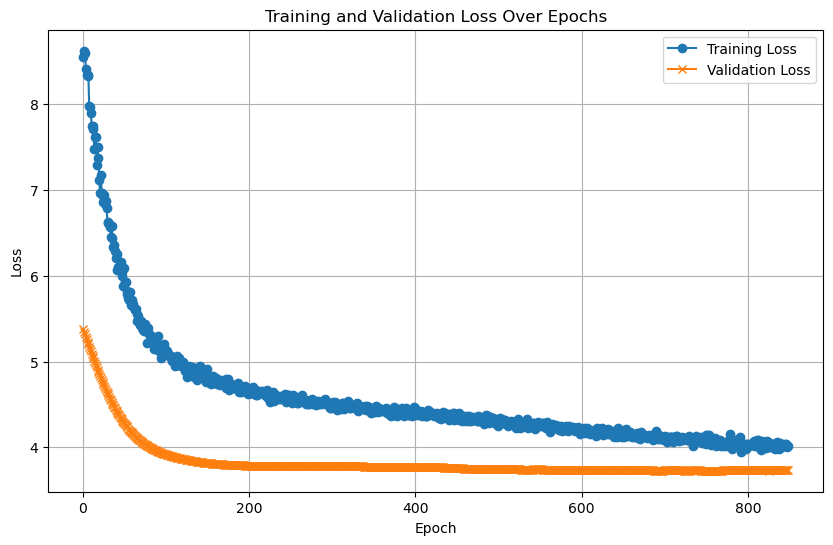

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 4.9368
Test Batch [20/20], Loss: 5.0051

Test Loss: 5.0277


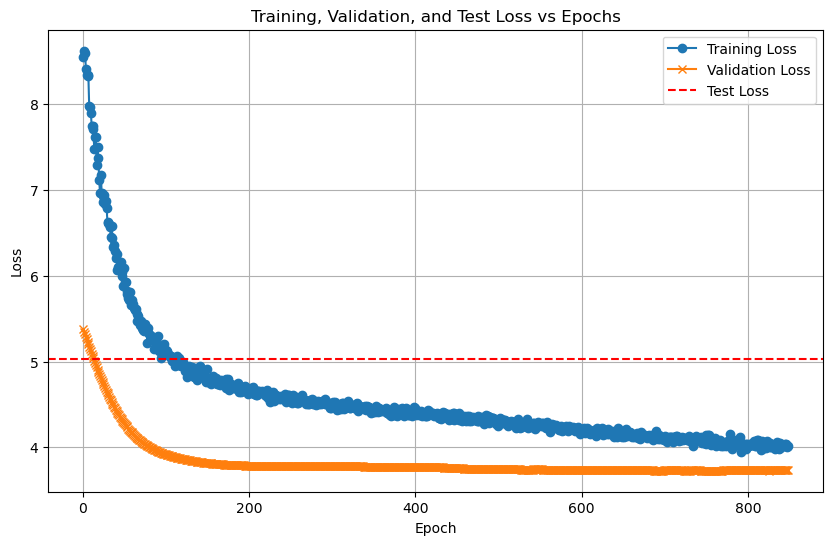

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 43.08%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.20      0.20      0.20         5
           2       0.50      0.20      0.29         5
           3       0.00      0.00      0.00         5
           4       0.50      0.40      0.44         5
           5       0.00      0.00      0.00         5
           6       0.25      0.80      0.38         5
           7       0.43      0.60      0.50         5
           8       0.57      0.80      0.67         5
           9       0.00      0.00      0.00         5
          10       1.00      0.80      0.89         5
          11       0.33      0.20      0.25         5
          12       0.71      1.00      0.83         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7134  |  Val Loss: 2.6504
Validation loss improved from inf to 2.6504.
[Epoch 2/1000] Train Loss: 2.6898  |  Val Loss: 2.6354
Validation loss improved from 2.6504 to 2.6354.
[Epoch 3/1000] Train Loss: 2.6673  |  Val Loss: 2.6234
Validation loss improved from 2.6354 to 2.6234.
[Epoch 4/1000] Train Loss: 2.6503  |  Val Loss: 2.6132
Validation loss improved from 2.6234 to 2.6132.
[Epoch 5/1000] Train Loss: 2.6369  |  Val Loss: 2.6054
Validation loss improved from 2.6132 to 2.6054.
[Epoch 6/1000] Train Loss: 2.6259  |  Val Loss: 2.5999
Validation loss improved from 2.6054 to 2.5999.
[Epoch 7/1000] Train Loss: 2.6176  |  Val Loss: 2.5950
Validation loss improved from 2.5999 to 2.5950.
[Epoch 8/1000] Train Loss: 2.6106  |  Val Loss: 2.5906
Validation loss improved from 2.5950 to 2.5906.
[Epoch 9/1000] Train Loss: 2.6054  |  Val Loss: 2.5865
Validation loss improved from 2.5906 to 2.5865.
[Epoch 10/1000] Train Loss: 2.6003  |  Val Loss: 2.5826
Validation loss impr

[Epoch 19/1000] Train Loss: 2.5659  |  Val Loss: 2.5597
Validation loss improved from 2.5618 to 2.5597.
[Epoch 20/1000] Train Loss: 2.5630  |  Val Loss: 2.5576
Validation loss improved from 2.5597 to 2.5576.
[Epoch 21/1000] Train Loss: 2.5598  |  Val Loss: 2.5557
Validation loss improved from 2.5576 to 2.5557.
[Epoch 22/1000] Train Loss: 2.5564  |  Val Loss: 2.5540
Validation loss improved from 2.5557 to 2.5540.
[Epoch 23/1000] Train Loss: 2.5535  |  Val Loss: 2.5527
Validation loss improved from 2.5540 to 2.5527.
[Epoch 24/1000] Train Loss: 2.5513  |  Val Loss: 2.5522
Validation loss improved from 2.5527 to 2.5522.
[Epoch 25/1000] Train Loss: 2.5483  |  Val Loss: 2.5508
Validation loss improved from 2.5522 to 2.5508.


[Epoch 26/1000] Train Loss: 2.5439  |  Val Loss: 2.5496
Validation loss improved from 2.5508 to 2.5496.
[Epoch 27/1000] Train Loss: 2.5412  |  Val Loss: 2.5483
Validation loss improved from 2.5496 to 2.5483.
[Epoch 28/1000] Train Loss: 2.5384  |  Val Loss: 2.5467
Validation loss improved from 2.5483 to 2.5467.
[Epoch 29/1000] Train Loss: 2.5359  |  Val Loss: 2.5450
Validation loss improved from 2.5467 to 2.5450.
[Epoch 30/1000] Train Loss: 2.5329  |  Val Loss: 2.5436
Validation loss improved from 2.5450 to 2.5436.
[Epoch 31/1000] Train Loss: 2.5305  |  Val Loss: 2.5423
Validation loss improved from 2.5436 to 2.5423.
[Epoch 32/1000] Train Loss: 2.5282  |  Val Loss: 2.5409
Validation loss improved from 2.5423 to 2.5409.
[Epoch 33/1000] Train Loss: 2.5258  |  Val Loss: 2.5395
Validation loss improved from 2.5409 to 2.5395.
[Epoch 34/1000] Train Loss: 2.5231  |  Val Loss: 2.5382
Validation loss improved from 2.5395 to 2.5382.
[Epoch 35/1000] Train Loss: 2.5205  |  Val Loss: 2.5369
Validati

[Epoch 51/1000] Train Loss: 2.4865  |  Val Loss: 2.5216
Validation loss improved from 2.5224 to 2.5216.
[Epoch 52/1000] Train Loss: 2.4846  |  Val Loss: 2.5208
Validation loss improved from 2.5216 to 2.5208.
[Epoch 53/1000] Train Loss: 2.4828  |  Val Loss: 2.5199
Validation loss improved from 2.5208 to 2.5199.
[Epoch 54/1000] Train Loss: 2.4810  |  Val Loss: 2.5189
Validation loss improved from 2.5199 to 2.5189.
[Epoch 55/1000] Train Loss: 2.4792  |  Val Loss: 2.5178
Validation loss improved from 2.5189 to 2.5178.
[Epoch 56/1000] Train Loss: 2.4777  |  Val Loss: 2.5171
Validation loss improved from 2.5178 to 2.5171.


[Epoch 57/1000] Train Loss: 2.4762  |  Val Loss: 2.5162
Validation loss improved from 2.5171 to 2.5162.
[Epoch 58/1000] Train Loss: 2.4746  |  Val Loss: 2.5147
Validation loss improved from 2.5162 to 2.5147.
[Epoch 59/1000] Train Loss: 2.4723  |  Val Loss: 2.5122
Validation loss improved from 2.5147 to 2.5122.
[Epoch 60/1000] Train Loss: 2.4698  |  Val Loss: 2.5103
Validation loss improved from 2.5122 to 2.5103.
[Epoch 61/1000] Train Loss: 2.4690  |  Val Loss: 2.5086
Validation loss improved from 2.5103 to 2.5086.
[Epoch 62/1000] Train Loss: 2.4676  |  Val Loss: 2.5074
Validation loss improved from 2.5086 to 2.5074.
[Epoch 63/1000] Train Loss: 2.4665  |  Val Loss: 2.5063
Validation loss improved from 2.5074 to 2.5063.
[Epoch 64/1000] Train Loss: 2.4650  |  Val Loss: 2.5054
Validation loss improved from 2.5063 to 2.5054.
[Epoch 65/1000] Train Loss: 2.4636  |  Val Loss: 2.5047
Validation loss improved from 2.5054 to 2.5047.
[Epoch 66/1000] Train Loss: 2.4622  |  Val Loss: 2.5041
Validati

[Epoch 83/1000] Train Loss: 2.4404  |  Val Loss: 2.4955
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 84/1000] Train Loss: 2.4393  |  Val Loss: 2.4953
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 85/1000] Train Loss: 2.4382  |  Val Loss: 2.4950
Validation loss improved from 2.4952 to 2.4950.
[Epoch 86/1000] Train Loss: 2.4366  |  Val Loss: 2.4943
Validation loss improved from 2.4950 to 2.4943.
[Epoch 87/1000] Train Loss: 2.4350  |  Val Loss: 2.4937
Validation loss improved from 2.4943 to 2.4937.
[Epoch 88/1000] Train Loss: 2.4336  |  Val Loss: 2.4930
Validation loss improved from 2.4937 to 2.4930.
[Epoch 89/1000] Train Loss: 2.4319  |  Val Loss: 2.4921
Validation loss improved from 2.4930 to 2.4921.


[Epoch 90/1000] Train Loss: 2.4303  |  Val Loss: 2.4915
Validation loss improved from 2.4921 to 2.4915.
[Epoch 91/1000] Train Loss: 2.4289  |  Val Loss: 2.4912
Validation loss improved from 2.4915 to 2.4912.
[Epoch 92/1000] Train Loss: 2.4275  |  Val Loss: 2.4910
Validation loss improved from 2.4912 to 2.4910.
[Epoch 93/1000] Train Loss: 2.4261  |  Val Loss: 2.4908
Validation loss improved from 2.4910 to 2.4908.
[Epoch 94/1000] Train Loss: 2.4249  |  Val Loss: 2.4906
Validation loss improved from 2.4908 to 2.4906.
[Epoch 95/1000] Train Loss: 2.4238  |  Val Loss: 2.4900
Validation loss improved from 2.4906 to 2.4900.
[Epoch 96/1000] Train Loss: 2.4223  |  Val Loss: 2.4890
Validation loss improved from 2.4900 to 2.4890.
[Epoch 97/1000] Train Loss: 2.4213  |  Val Loss: 2.4889
Validation loss improved from 2.4890 to 2.4889.
[Epoch 98/1000] Train Loss: 2.4197  |  Val Loss: 2.4888
Validation loss improved from 2.4889 to 2.4888.
[Epoch 99/1000] Train Loss: 2.4190  |  Val Loss: 2.4884
Validati

[Epoch 114/1000] Train Loss: 2.4103  |  Val Loss: 2.4869
Validation loss improved from 2.4872 to 2.4869.
[Epoch 115/1000] Train Loss: 2.4093  |  Val Loss: 2.4851
Validation loss improved from 2.4869 to 2.4851.
[Epoch 116/1000] Train Loss: 2.4068  |  Val Loss: 2.4838
Validation loss improved from 2.4851 to 2.4838.
[Epoch 117/1000] Train Loss: 2.4048  |  Val Loss: 2.4832
Validation loss improved from 2.4838 to 2.4832.
[Epoch 118/1000] Train Loss: 2.4035  |  Val Loss: 2.4823
Validation loss improved from 2.4832 to 2.4823.
[Epoch 119/1000] Train Loss: 2.4018  |  Val Loss: 2.4814
Validation loss improved from 2.4823 to 2.4814.
[Epoch 120/1000] Train Loss: 2.4000  |  Val Loss: 2.4807
Validation loss improved from 2.4814 to 2.4807.
[Epoch 121/1000] Train Loss: 2.3984  |  Val Loss: 2.4803
Validation loss improved from 2.4807 to 2.4803.


[Epoch 122/1000] Train Loss: 2.3972  |  Val Loss: 2.4804
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 123/1000] Train Loss: 2.3961  |  Val Loss: 2.4802
Validation loss improved from 2.4803 to 2.4802.
[Epoch 124/1000] Train Loss: 2.3950  |  Val Loss: 2.4790
Validation loss improved from 2.4802 to 2.4790.
[Epoch 125/1000] Train Loss: 2.3928  |  Val Loss: 2.4770
Validation loss improved from 2.4790 to 2.4770.
[Epoch 126/1000] Train Loss: 2.3902  |  Val Loss: 2.4761
Validation loss improved from 2.4770 to 2.4761.
[Epoch 127/1000] Train Loss: 2.3884  |  Val Loss: 2.4760
Validation loss improved from 2.4761 to 2.4760.
[Epoch 128/1000] Train Loss: 2.3865  |  Val Loss: 2.4759
Validation loss improved from 2.4760 to 2.4759.
[Epoch 129/1000] Train Loss: 2.3855  |  Val Loss: 2.4758
Validation loss improved from 2.4759 to 2.4758.
[Epoch 130/1000] Train Loss: 2.3841  |  Val Loss: 2.4755
Validation loss improved from 2.4758 to 2.4755.
[Epoch 131/1000] Train Loss: 2.3828  |  Val Loss:

[Epoch 146/1000] Train Loss: 2.3659  |  Val Loss: 2.4673
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 147/1000] Train Loss: 2.3647  |  Val Loss: 2.4686
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 148/1000] Train Loss: 2.3638  |  Val Loss: 2.4712
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 149/1000] Train Loss: 2.3632  |  Val Loss: 2.4743
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 150/1000] Train Loss: 2.3633  |  Val Loss: 2.4762
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 151/1000] Train Loss: 2.3624  |  Val Loss: 2.4775
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 152/1000] Train Loss: 2.3609  |  Val Loss: 2.4788
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 153/1000] Train Loss: 2.3592  |  Val Loss: 2.4793
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 154/1000] Train Loss: 2.3571  |  Val Loss: 2.4789
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 155/1000] Train Loss: 2.3560  |  Val Loss: 2.4783
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 156/1000] Train Loss: 2.3543  |  Val Loss: 2.4776
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 157/1000] Train Loss: 2.3531  |  Val Loss: 2.4769
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 158/1000] Train Loss: 2.3518  |  Val Loss: 2.4761
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 159/1000] Train Loss: 2.3507  |  Val Loss: 2.4750
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 160/1000] Train Loss: 2.3494  |  Val Loss: 2.4742
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 161/1000] Train Loss: 2.3482  |  Val Loss: 2.4740
!! Validation loss did NOT improve !! Patience: 

[Epoch 178/1000] Train Loss: 2.3254  |  Val Loss: 2.4583
Validation loss improved from 2.4601 to 2.4583.
[Epoch 179/1000] Train Loss: 2.3235  |  Val Loss: 2.4560
Validation loss improved from 2.4583 to 2.4560.
[Epoch 180/1000] Train Loss: 2.3220  |  Val Loss: 2.4539
Validation loss improved from 2.4560 to 2.4539.
[Epoch 181/1000] Train Loss: 2.3207  |  Val Loss: 2.4523
Validation loss improved from 2.4539 to 2.4523.
[Epoch 182/1000] Train Loss: 2.3187  |  Val Loss: 2.4508
Validation loss improved from 2.4523 to 2.4508.
[Epoch 183/1000] Train Loss: 2.3165  |  Val Loss: 2.4488
Validation loss improved from 2.4508 to 2.4488.
[Epoch 184/1000] Train Loss: 2.3159  |  Val Loss: 2.4473
Validation loss improved from 2.4488 to 2.4473.


[Epoch 185/1000] Train Loss: 2.3138  |  Val Loss: 2.4465
Validation loss improved from 2.4473 to 2.4465.
[Epoch 186/1000] Train Loss: 2.3124  |  Val Loss: 2.4456
Validation loss improved from 2.4465 to 2.4456.
[Epoch 187/1000] Train Loss: 2.3112  |  Val Loss: 2.4447
Validation loss improved from 2.4456 to 2.4447.
[Epoch 188/1000] Train Loss: 2.3103  |  Val Loss: 2.4435
Validation loss improved from 2.4447 to 2.4435.
[Epoch 189/1000] Train Loss: 2.3097  |  Val Loss: 2.4417
Validation loss improved from 2.4435 to 2.4417.
[Epoch 190/1000] Train Loss: 2.3092  |  Val Loss: 2.4404
Validation loss improved from 2.4417 to 2.4404.
[Epoch 191/1000] Train Loss: 2.3085  |  Val Loss: 2.4401
Validation loss improved from 2.4404 to 2.4401.
[Epoch 192/1000] Train Loss: 2.3063  |  Val Loss: 2.4408
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 193/1000] Train Loss: 2.3046  |  Val Loss: 2.4411
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 194/1000] Train Loss: 2.3026  |  Val

[Epoch 212/1000] Train Loss: 2.2741  |  Val Loss: 2.4324
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 213/1000] Train Loss: 2.2720  |  Val Loss: 2.4302
Validation loss improved from 2.4320 to 2.4302.
[Epoch 214/1000] Train Loss: 2.2691  |  Val Loss: 2.4295
Validation loss improved from 2.4302 to 2.4295.
[Epoch 215/1000] Train Loss: 2.2668  |  Val Loss: 2.4291
Validation loss improved from 2.4295 to 2.4291.
[Epoch 216/1000] Train Loss: 2.2649  |  Val Loss: 2.4286
Validation loss improved from 2.4291 to 2.4286.
[Epoch 217/1000] Train Loss: 2.2632  |  Val Loss: 2.4279
Validation loss improved from 2.4286 to 2.4279.
[Epoch 218/1000] Train Loss: 2.2620  |  Val Loss: 2.4272
Validation loss improved from 2.4279 to 2.4272.
[Epoch 219/1000] Train Loss: 2.2610  |  Val Loss: 2.4266
Validation loss improved from 2.4272 to 2.4266.
[Epoch 220/1000] Train Loss: 2.2596  |  Val Loss: 2.4256
Validation loss improved from 2.4266 to 2.4256.
[Epoch 221/1000] Train Loss: 2.2579  |  Val Loss: 2.4252
Validation loss improved from 2.4256 to 2.4252.
[Epoch 222/1000] Train Loss: 2.2565  |  Val Loss: 2.425

[Epoch 244/1000] Train Loss: 2.2148  |  Val Loss: 2.3981
Validation loss improved from 2.3988 to 2.3981.
[Epoch 245/1000] Train Loss: 2.2128  |  Val Loss: 2.3980
Validation loss improved from 2.3981 to 2.3980.
[Epoch 246/1000] Train Loss: 2.2110  |  Val Loss: 2.3979
Validation loss improved from 2.3980 to 2.3979.
[Epoch 247/1000] Train Loss: 2.2092  |  Val Loss: 2.3971
Validation loss improved from 2.3979 to 2.3971.
[Epoch 248/1000] Train Loss: 2.2067  |  Val Loss: 2.3963
Validation loss improved from 2.3971 to 2.3963.
[Epoch 249/1000] Train Loss: 2.2050  |  Val Loss: 2.3959
Validation loss improved from 2.3963 to 2.3959.
[Epoch 250/1000] Train Loss: 2.2035  |  Val Loss: 2.3957
Validation loss improved from 2.3959 to 2.3957.
[Epoch 251/1000] Train Loss: 2.2013  |  Val Loss: 2.3964
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 252/1000] Train Loss: 2.1987  |  Val Loss: 2.3986
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 253/1000] Train Loss: 2.1969  |  Val

[Epoch 271/1000] Train Loss: 2.1624  |  Val Loss: 2.3853
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 272/1000] Train Loss: 2.1598  |  Val Loss: 2.3844
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 273/1000] Train Loss: 2.1573  |  Val Loss: 2.3820
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 274/1000] Train Loss: 2.1545  |  Val Loss: 2.3781
Validation loss improved from 2.3817 to 2.3781.
[Epoch 275/1000] Train Loss: 2.1513  |  Val Loss: 2.3750
Validation loss improved from 2.3781 to 2.3750.
[Epoch 276/1000] Train Loss: 2.1491  |  Val Loss: 2.3729
Validation loss improved from 2.3750 to 2.3729.
[Epoch 277/1000] Train Loss: 2.1473  |  Val Loss: 2.3712
Validation loss improved from 2.3729 to 2.3712.
[Epoch 278/1000] Train Loss: 2.1458  |  Val Loss: 2.3701
Validation loss improved from 2.3712 to 2.3701.
[Epoch 279/1000] Train Loss: 2.1434  |  Val Loss: 2.3696
Validation loss improved from 2.3701 to 2.3696.
[Epoch 280/1000] Train Loss: 2.1414 

[Epoch 302/1000] Train Loss: 2.0973  |  Val Loss: 2.3551
Validation loss improved from 2.3571 to 2.3551.
[Epoch 303/1000] Train Loss: 2.0945  |  Val Loss: 2.3538
Validation loss improved from 2.3551 to 2.3538.
[Epoch 304/1000] Train Loss: 2.0916  |  Val Loss: 2.3537
Validation loss improved from 2.3538 to 2.3537.
[Epoch 305/1000] Train Loss: 2.0888  |  Val Loss: 2.3525
Validation loss improved from 2.3537 to 2.3525.
[Epoch 306/1000] Train Loss: 2.0862  |  Val Loss: 2.3506
Validation loss improved from 2.3525 to 2.3506.
[Epoch 307/1000] Train Loss: 2.0834  |  Val Loss: 2.3485
Validation loss improved from 2.3506 to 2.3485.
[Epoch 308/1000] Train Loss: 2.0810  |  Val Loss: 2.3467
Validation loss improved from 2.3485 to 2.3467.
[Epoch 309/1000] Train Loss: 2.0787  |  Val Loss: 2.3443
Validation loss improved from 2.3467 to 2.3443.
[Epoch 310/1000] Train Loss: 2.0756  |  Val Loss: 2.3411
Validation loss improved from 2.3443 to 2.3411.
[Epoch 311/1000] Train Loss: 2.0725  |  Val Loss: 2.338

[Epoch 334/1000] Train Loss: 2.0155  |  Val Loss: 2.3187
Validation loss improved from 2.3203 to 2.3187.
[Epoch 335/1000] Train Loss: 2.0121  |  Val Loss: 2.3189
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 336/1000] Train Loss: 2.0088  |  Val Loss: 2.3186
Validation loss improved from 2.3187 to 2.3186.
[Epoch 337/1000] Train Loss: 2.0060  |  Val Loss: 2.3176
Validation loss improved from 2.3186 to 2.3176.
[Epoch 338/1000] Train Loss: 2.0033  |  Val Loss: 2.3165
Validation loss improved from 2.3176 to 2.3165.
[Epoch 339/1000] Train Loss: 2.0009  |  Val Loss: 2.3150
Validation loss improved from 2.3165 to 2.3150.
[Epoch 340/1000] Train Loss: 1.9985  |  Val Loss: 2.3129
Validation loss improved from 2.3150 to 2.3129.
[Epoch 341/1000] Train Loss: 1.9960  |  Val Loss: 2.3119
Validation loss improved from 2.3129 to 2.3119.
[Epoch 342/1000] Train Loss: 1.9929  |  Val Loss: 2.3115
Validation loss improved from 2.3119 to 2.3115.
[Epoch 343/1000] Train Loss: 1.9903  |  Val Loss:

[Epoch 363/1000] Train Loss: 1.9346  |  Val Loss: 2.2998
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 364/1000] Train Loss: 1.9317  |  Val Loss: 2.2987
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 365/1000] Train Loss: 1.9287  |  Val Loss: 2.2975
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 366/1000] Train Loss: 1.9262  |  Val Loss: 2.2958
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 367/1000] Train Loss: 1.9238  |  Val Loss: 2.2941
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 368/1000] Train Loss: 1.9214  |  Val Loss: 2.2919
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 369/1000] Train Loss: 1.9187  |  Val Loss: 2.2900
Validation loss improved from 2.2915 to 2.2900.
[Epoch 370/1000] Train Loss: 1.9161  |  Val Loss: 2.2880
Validation loss improved from 2.2900 to 2.2880.
[Epoch 371/1000] Train Loss: 1.9135  |  Val Loss: 2.2860
Validation loss improved from 2.2880 to 2.2860.
[Epoch 372/10

[Epoch 394/1000] Train Loss: 1.8542  |  Val Loss: 2.2934
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 395/1000] Train Loss: 1.8514  |  Val Loss: 2.2927
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 396/1000] Train Loss: 1.8481  |  Val Loss: 2.2924
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 397/1000] Train Loss: 1.8453  |  Val Loss: 2.2934
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 398/1000] Train Loss: 1.8426  |  Val Loss: 2.2957
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 399/1000] Train Loss: 1.8406  |  Val Loss: 2.2967
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 400/1000] Train Loss: 1.8388  |  Val Loss: 2.2935
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 401/1000] Train Loss: 1.8364  |  Val Loss: 2.2827
Validation loss improved from 2.2853 to 2.2827.
[Epoch 402/1000] Train Loss: 1.8342  |  Val Loss: 2.2748
Validation loss improved from 2.2827 to 2.2748.
[Epoch

[Epoch 426/1000] Train Loss: 1.7648  |  Val Loss: 2.2140
Validation loss improved from 2.2153 to 2.2140.
[Epoch 427/1000] Train Loss: 1.7625  |  Val Loss: 2.2131
Validation loss improved from 2.2140 to 2.2131.
[Epoch 428/1000] Train Loss: 1.7601  |  Val Loss: 2.2135
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 429/1000] Train Loss: 1.7574  |  Val Loss: 2.2153
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 430/1000] Train Loss: 1.7545  |  Val Loss: 2.2166
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 431/1000] Train Loss: 1.7524  |  Val Loss: 2.2171
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 432/1000] Train Loss: 1.7497  |  Val Loss: 2.2154
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 433/1000] Train Loss: 1.7475  |  Val Loss: 2.2117
Validation loss improved from 2.2131 to 2.2117.
[Epoch 434/1000] Train Loss: 1.7452  |  Val Loss: 2.2103
Validation loss improved from 2.2117 to 2.2103.
[Epoch 435/1000] Train Lo

[Epoch 455/1000] Train Loss: 1.6910  |  Val Loss: 2.2415
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 456/1000] Train Loss: 1.6894  |  Val Loss: 2.2453
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 457/1000] Train Loss: 1.6880  |  Val Loss: 2.2479
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 458/1000] Train Loss: 1.6861  |  Val Loss: 2.2497
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 459/1000] Train Loss: 1.6839  |  Val Loss: 2.2505
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 460/1000] Train Loss: 1.6813  |  Val Loss: 2.2525
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 461/1000] Train Loss: 1.6794  |  Val Loss: 2.2553
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 462/1000] Train Loss: 1.6774  |  Val Loss: 2.2560
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 463/1000] Train Loss: 1.6744  |  Val Loss: 2.2544
!! Validation loss did NOT improve !! Patience:

[Epoch 484/1000] Train Loss: 1.6190  |  Val Loss: 2.2216
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 485/1000] Train Loss: 1.6163  |  Val Loss: 2.2277
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 486/1000] Train Loss: 1.6140  |  Val Loss: 2.2322
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 487/1000] Train Loss: 1.6122  |  Val Loss: 2.2357
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 488/1000] Train Loss: 1.6100  |  Val Loss: 2.2376
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 489/1000] Train Loss: 1.6078  |  Val Loss: 2.2386
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 490/1000] Train Loss: 1.6057  |  Val Loss: 2.2394
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 491/1000] Train Loss: 1.6036  |  Val Loss: 2.2422
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 492/1000] Train Loss: 1.6019  |  Val Loss: 2.2455
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 514/1000] Train Loss: 1.5552  |  Val Loss: 2.2240
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 515/1000] Train Loss: 1.5531  |  Val Loss: 2.2280
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 516/1000] Train Loss: 1.5515  |  Val Loss: 2.2318
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 517/1000] Train Loss: 1.5499  |  Val Loss: 2.2337
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 518/1000] Train Loss: 1.5479  |  Val Loss: 2.2355
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 519/1000] Train Loss: 1.5462  |  Val Loss: 2.2348
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 520/1000] Train Loss: 1.5439  |  Val Loss: 2.2320
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 521/1000] Train Loss: 1.5413  |  Val Loss: 2.2274
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 522/1000] Train Loss: 1.5388  |  Val Loss: 2.2234
!! Validation loss did NOT improve !! Patience:

[Epoch 542/1000] Train Loss: 1.5045  |  Val Loss: 2.2133
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 543/1000] Train Loss: 1.5036  |  Val Loss: 2.2122
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 544/1000] Train Loss: 1.5023  |  Val Loss: 2.2127
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 545/1000] Train Loss: 1.5012  |  Val Loss: 2.2136
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 546/1000] Train Loss: 1.4995  |  Val Loss: 2.2138
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 547/1000] Train Loss: 1.4973  |  Val Loss: 2.2142
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 548/1000] Train Loss: 1.4944  |  Val Loss: 2.2155
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 549/1000] Train Loss: 1.4912  |  Val Loss: 2.2169
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 550/1000] Train Loss: 1.4883  |  Val Loss: 2.2183
!! Validation loss did NOT improve !! Patience:

[Epoch 573/1000] Train Loss: 1.4502  |  Val Loss: 2.2306
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 574/1000] Train Loss: 1.4481  |  Val Loss: 2.2279
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 575/1000] Train Loss: 1.4450  |  Val Loss: 2.2256
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 576/1000] Train Loss: 1.4416  |  Val Loss: 2.2231
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 577/1000] Train Loss: 1.4383  |  Val Loss: 2.2199
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 578/1000] Train Loss: 1.4353  |  Val Loss: 2.2173
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 578 !!
No improvement for 100 epochs.


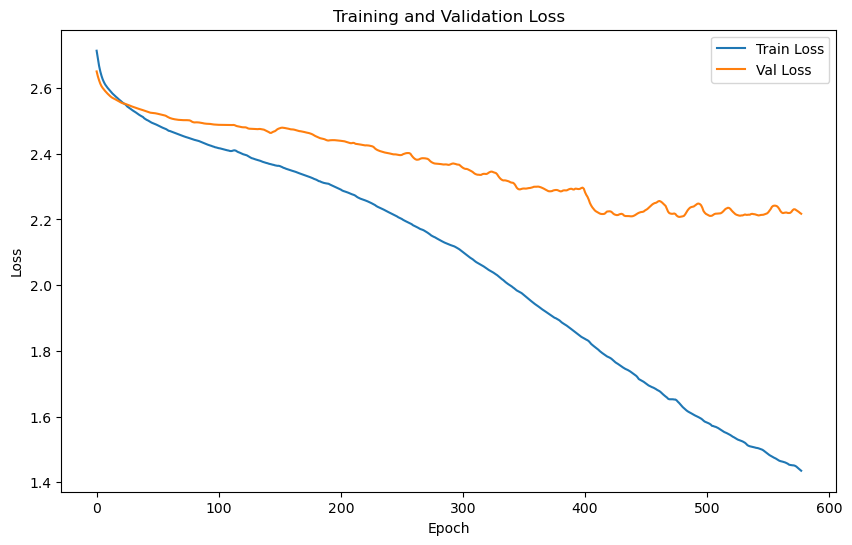

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.2616 | Test Accuracy: 43.68%


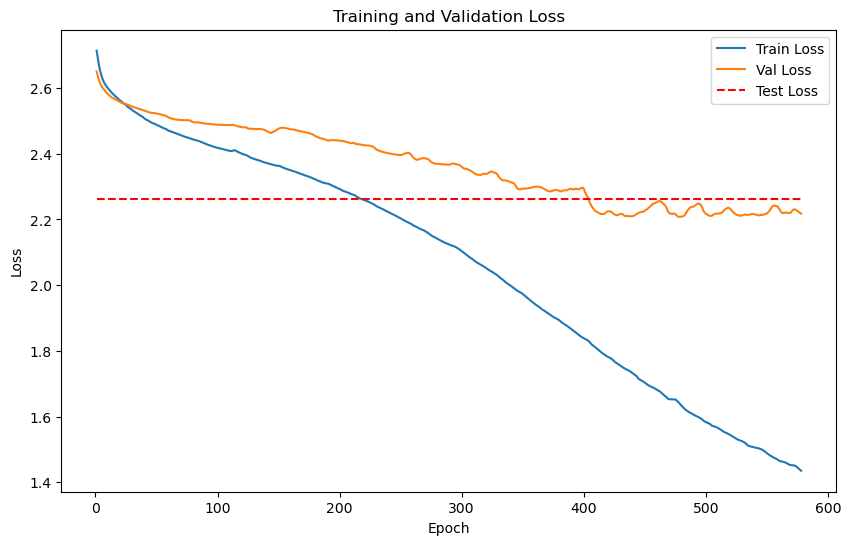

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)


Train embeddings shape: (130, 64), 
Train labels shape: (130,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5016, 64), 
Test labels shape: (5016,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}
Training batch size: 130


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5337
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.6540
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5337, Avg Val Loss: 0.5770

Validation loss improved from inf to 0.5770. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5336
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.6530
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5336, Avg Val Loss: 0.5765

Validation loss improved from 0.5770 to 0.5765. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5319
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.6518
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5319, Avg Val Loss: 0.5759

Validation loss improved from 0.5765 to 0.5759. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.5345
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.6505
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5345, Avg Val Loss: 0.5753

Validation loss improved from 0.5759 to 0.5753. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5273
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.6498
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5273, Avg Val Loss: 0.5749

Validation loss improved from 0.5753 to 0.5749. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.5359
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.6485
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5359, Avg Val Loss: 0.5742

Validation loss improved from 0.5749 to 0.5742. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.5330
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.6467
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5330, Avg Val Loss: 0.5734

Validation loss improved from 0.5742 to 0.5734. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.5307
LOG: Epoch [8/2000] - Validation


    Batch [1/2], Val Loss: 0.6448
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5307, Avg Val Loss: 0.5724

Validation loss improved from 0.5734 to 0.5724. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.5283
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.6430
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5283, Avg Val Loss: 0.5715

Validation loss improved from 0.5724 to 0.5715. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.5261
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.6415
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5261, Avg Val Loss: 0.5707

Validation loss improved from 0.5715 to 0.5707. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.5239
LOG: Epoch [11/2000] - Validation


    Batch [1/2], Val Loss: 0.6392
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5239, Avg Val Loss: 0.5696

Validation loss improved from 0.5707 to 0.5696. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.5273
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.6370
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5273, Avg Val Loss: 0.5685

Validation loss improved from 0.5696 to 0.5685. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.5273
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.6342
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5273, Avg Val Loss: 0.5671

Validation loss improved from 0.5685 to 0.5671. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.5203
LOG: Epoch [14/2000] - Validation


    Batch [1/2], Val Loss: 0.6306
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5203, Avg Val Loss: 0.5653

Validation loss improved from 0.5671 to 0.5653. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.5229
LOG: Epoch [15/2000] - Validation


    Batch [1/2], Val Loss: 0.6272
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5229, Avg Val Loss: 0.5636

Validation loss improved from 0.5653 to 0.5636. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.5247
LOG: Epoch [16/2000] - Validation


    Batch [1/2], Val Loss: 0.6241
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5247, Avg Val Loss: 0.5620

Validation loss improved from 0.5636 to 0.5620. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.5244
LOG: Epoch [17/2000] - Validation


    Batch [1/2], Val Loss: 0.6215
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5244, Avg Val Loss: 0.5608

Validation loss improved from 0.5620 to 0.5608. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.5185
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.6186
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5185, Avg Val Loss: 0.5593

Validation loss improved from 0.5608 to 0.5593. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.5221
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.6151
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5221, Avg Val Loss: 0.5575

Validation loss improved from 0.5593 to 0.5575. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.5204
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.6106
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5204, Avg Val Loss: 0.5553

Validation loss improved from 0.5575 to 0.5553. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.5175
LOG: Epoch [21/2000] - Validation


    Batch [1/2], Val Loss: 0.6062
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5175, Avg Val Loss: 0.5531

Validation loss improved from 0.5553 to 0.5531. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.5172
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.6019


    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5172, Avg Val Loss: 0.5510

Validation loss improved from 0.5531 to 0.5510. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.5166
LOG: Epoch [23/2000] - Validation


    Batch [1/2], Val Loss: 0.5978
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5166, Avg Val Loss: 0.5489

Validation loss improved from 0.5510 to 0.5489. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.5205
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5940
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5205, Avg Val Loss: 0.5470

Validation loss improved from 0.5489 to 0.5470. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.5204
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5910
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5204, Avg Val Loss: 0.5455

Validation loss improved from 0.5470 to 0.5455. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.5171
LOG: Epoch [26/2000] - Validation


    Batch [1/2], Val Loss: 0.5880
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5171, Avg Val Loss: 0.5440

Validation loss improved from 0.5455 to 0.5440. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.5179
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5852
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5179, Avg Val Loss: 0.5426

Validation loss improved from 0.5440 to 0.5426. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.5192
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5820
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5192, Avg Val Loss: 0.5410

Validation loss improved from 0.5426 to 0.5410. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.5147
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.5787
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5147, Avg Val Loss: 0.5394

Validation loss improved from 0.5410 to 0.5394. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.5151
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5756
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5151, Avg Val Loss: 0.5378

Validation loss improved from 0.5394 to 0.5378. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.5122
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5730
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5122, Avg Val Loss: 0.5365

Validation loss improved from 0.5378 to 0.5365. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.5142
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5705
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5142, Avg Val Loss: 0.5352

Validation loss improved from 0.5365 to 0.5352. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.5120
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5679
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5120, Avg Val Loss: 0.5340

Validation loss improved from 0.5352 to 0.5340. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.5123
LOG: Epoch [34/2000] - Validation


    Batch [1/2], Val Loss: 0.5656
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5123, Avg Val Loss: 0.5328

Validation loss improved from 0.5340 to 0.5328. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.5124
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5635
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5124, Avg Val Loss: 0.5317

Validation loss improved from 0.5328 to 0.5317. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.5100
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5617
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5100, Avg Val Loss: 0.5309

Validation loss improved from 0.5317 to 0.5309. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.5081
LOG: Epoch [37/2000] - Validation


    Batch [1/2], Val Loss: 0.5600
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5081, Avg Val Loss: 0.5300

Validation loss improved from 0.5309 to 0.5300. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.5103
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5582
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5103, Avg Val Loss: 0.5291

Validation loss improved from 0.5300 to 0.5291. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.5140
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5566
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5140, Avg Val Loss: 0.5283

Validation loss improved from 0.5291 to 0.5283. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.5075
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5550
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5075, Avg Val Loss: 0.5275

Validation loss improved from 0.5283 to 0.5275. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.5112
LOG: Epoch [41/2000] - Validation


    Batch [1/2], Val Loss: 0.5536
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5112, Avg Val Loss: 0.5268

Validation loss improved from 0.5275 to 0.5268. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.5084
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5523
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5084, Avg Val Loss: 0.5261

Validation loss improved from 0.5268 to 0.5261. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.5040
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5510
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5040, Avg Val Loss: 0.5255

Validation loss improved from 0.5261 to 0.5255. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.5071
LOG: Epoch [44/2000] - Validation


    Batch [1/2], Val Loss: 0.5498
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5071, Avg Val Loss: 0.5249

Validation loss improved from 0.5255 to 0.5249. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.5080
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5486
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5080, Avg Val Loss: 0.5243

Validation loss improved from 0.5249 to 0.5243. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.5074
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5474
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5074, Avg Val Loss: 0.5237

Validation loss improved from 0.5243 to 0.5237. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.5101
LOG: Epoch [47/2000] - Validation


    Batch [1/2], Val Loss: 0.5462
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5101, Avg Val Loss: 0.5231

Validation loss improved from 0.5237 to 0.5231. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.5117
LOG: Epoch [48/2000] - Validation


    Batch [1/2], Val Loss: 0.5451
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5117, Avg Val Loss: 0.5225

Validation loss improved from 0.5231 to 0.5225. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.5056
LOG: Epoch [49/2000] - Validation


    Batch [1/2], Val Loss: 0.5440
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5056, Avg Val Loss: 0.5220

Validation loss improved from 0.5225 to 0.5220. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.5030
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5429
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5030, Avg Val Loss: 0.5215

Validation loss improved from 0.5220 to 0.5215. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.5028
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5419
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5028, Avg Val Loss: 0.5210

Validation loss improved from 0.5215 to 0.5210. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.5085
LOG: Epoch [52/2000] - Validation


    Batch [1/2], Val Loss: 0.5409
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5085, Avg Val Loss: 0.5205

Validation loss improved from 0.5210 to 0.5205. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.5051
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5399
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5051, Avg Val Loss: 0.5200

Validation loss improved from 0.5205 to 0.5200. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.5049
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.5390
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5049, Avg Val Loss: 0.5195

Validation loss improved from 0.5200 to 0.5195. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.5078
LOG: Epoch [55/2000] - Validation


    Batch [1/2], Val Loss: 0.5381
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5078, Avg Val Loss: 0.5191

Validation loss improved from 0.5195 to 0.5191. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.5032
LOG: Epoch [56/2000] - Validation


    Batch [1/2], Val Loss: 0.5373
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.5032, Avg Val Loss: 0.5186

Validation loss improved from 0.5191 to 0.5186. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.5029
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5364
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.5029, Avg Val Loss: 0.5182

Validation loss improved from 0.5186 to 0.5182. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.5042
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5356
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.5042, Avg Val Loss: 0.5178

Validation loss improved from 0.5182 to 0.5178. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.5031
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5349
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.5031, Avg Val Loss: 0.5174

Validation loss improved from 0.5178 to 0.5174. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.5060
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.5341
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5060, Avg Val Loss: 0.5171

Validation loss improved from 0.5174 to 0.5171. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.5017
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.5335
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.5017, Avg Val Loss: 0.5167

Validation loss improved from 0.5171 to 0.5167. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.5060
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5329
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.5060, Avg Val Loss: 0.5165

Validation loss improved from 0.5167 to 0.5165. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.5049
LOG: Epoch [63/2000] - Validation


    Batch [1/2], Val Loss: 0.5324
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.5049, Avg Val Loss: 0.5162

Validation loss improved from 0.5165 to 0.5162. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.5029
LOG: Epoch [64/2000] - Validation


    Batch [1/2], Val Loss: 0.5318
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.5029, Avg Val Loss: 0.5159

Validation loss improved from 0.5162 to 0.5159. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.5041
LOG: Epoch [65/2000] - Validation


    Batch [1/2], Val Loss: 0.5313
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.5157

Validation loss improved from 0.5159 to 0.5157. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.5041
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5309
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.5154

Validation loss improved from 0.5157 to 0.5154. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5304
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5152

Validation loss improved from 0.5154 to 0.5152. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.5031
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5300
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.5031, Avg Val Loss: 0.5150

Validation loss improved from 0.5152 to 0.5150. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.5035
LOG: Epoch [69/2000] - Validation


    Batch [1/2], Val Loss: 0.5296
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.5035, Avg Val Loss: 0.5148

Validation loss improved from 0.5150 to 0.5148. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5292


    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.5146

Validation loss improved from 0.5148 to 0.5146. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4981
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5289
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.4981, Avg Val Loss: 0.5144

Validation loss improved from 0.5146 to 0.5144. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.5030
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.5030, Avg Val Loss: 0.5142

Validation loss improved from 0.5144 to 0.5142. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.5050
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5281
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.5050, Avg Val Loss: 0.5141

Validation loss improved from 0.5142 to 0.5141. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4992
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5278
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.4992, Avg Val Loss: 0.5139

Validation loss improved from 0.5141 to 0.5139. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4986
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.5275
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.4986, Avg Val Loss: 0.5138

Validation loss improved from 0.5139 to 0.5138. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.5003
LOG: Epoch [76/2000] - Validation


    Batch [1/2], Val Loss: 0.5273
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.5003, Avg Val Loss: 0.5136

Validation loss improved from 0.5138 to 0.5136. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.4999
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.5270
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.4999, Avg Val Loss: 0.5135

Validation loss improved from 0.5136 to 0.5135. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.5008
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5267
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.5008, Avg Val Loss: 0.5134

Validation loss improved from 0.5135 to 0.5134. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.5008
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5265
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.5008, Avg Val Loss: 0.5132

Validation loss improved from 0.5134 to 0.5132. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.4987
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.5262
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.4987, Avg Val Loss: 0.5131

Validation loss improved from 0.5132 to 0.5131. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.5259


    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5130

Validation loss improved from 0.5131 to 0.5130. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5256
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.5128

Validation loss improved from 0.5130 to 0.5128. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5254
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5127

Validation loss improved from 0.5128 to 0.5127. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4988
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.5251
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.4988, Avg Val Loss: 0.5126

Validation loss improved from 0.5127 to 0.5126. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4998
LOG: Epoch [85/2000] - Validation


    Batch [1/2], Val Loss: 0.5248
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.5124

Validation loss improved from 0.5126 to 0.5124. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [86/2000] - Validation


    Batch [1/2], Val Loss: 0.5245
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.5123

Validation loss improved from 0.5124 to 0.5123. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4977
LOG: Epoch [87/2000] - Validation


    Batch [1/2], Val Loss: 0.5243
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.5121

Validation loss improved from 0.5123 to 0.5121. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5240
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.5120

Validation loss improved from 0.5121 to 0.5120. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4982
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5236
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.4982, Avg Val Loss: 0.5118

Validation loss improved from 0.5120 to 0.5118. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5233
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5116

Validation loss improved from 0.5118 to 0.5116. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [91/2000] - Validation


    Batch [1/2], Val Loss: 0.5230
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5115

Validation loss improved from 0.5116 to 0.5115. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.5227
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5113

Validation loss improved from 0.5115 to 0.5113. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5224
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5112

Validation loss improved from 0.5113 to 0.5112. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.4969
LOG: Epoch [94/2000] - Validation


    Batch [1/2], Val Loss: 0.5222
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4969, Avg Val Loss: 0.5111

Validation loss improved from 0.5112 to 0.5111. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.4989
LOG: Epoch [95/2000] - Validation


    Batch [1/2], Val Loss: 0.5221
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.5110

Validation loss improved from 0.5111 to 0.5110. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.4979
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5219
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4979, Avg Val Loss: 0.5110

Validation loss improved from 0.5110 to 0.5110. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4974
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.5218
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4974, Avg Val Loss: 0.5109

Validation loss improved from 0.5110 to 0.5109. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [98/2000] - Validation


    Batch [1/2], Val Loss: 0.5216
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.5108

Validation loss improved from 0.5109 to 0.5108. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [99/2000] - Validation


    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.5107

Validation loss improved from 0.5108 to 0.5107. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [100/2000] - Validation


    Batch [1/2], Val Loss: 0.5211
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5106

Validation loss improved from 0.5107 to 0.5106. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.5209
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5105

Validation loss improved from 0.5106 to 0.5105. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5104

Validation loss improved from 0.5105 to 0.5104. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.5206
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5103

Validation loss improved from 0.5104 to 0.5103. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [104/2000] - Validation


    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5102

Validation loss improved from 0.5103 to 0.5102. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.5203
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.5101

Validation loss improved from 0.5102 to 0.5101. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.5201
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5101

Validation loss improved from 0.5101 to 0.5101. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.5200
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5100

Validation loss improved from 0.5101 to 0.5100. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.5199
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5100

Validation loss improved from 0.5100 to 0.5100. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5099

Validation loss improved from 0.5100 to 0.5099. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [110/2000] - Validation


    Batch [1/2], Val Loss: 0.5197
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5099

Validation loss improved from 0.5099 to 0.5099. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5098

Validation loss improved from 0.5099 to 0.5098. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5097

Validation loss improved from 0.5098 to 0.5097. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.5193
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5097

Validation loss improved from 0.5097 to 0.5097. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.5192
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5096

Validation loss improved from 0.5097 to 0.5096. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.5191
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5096

Validation loss improved from 0.5096 to 0.5096. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.5191
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5095

Validation loss improved from 0.5096 to 0.5095. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5095

Validation loss improved from 0.5095 to 0.5095. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.5189
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5095

Validation loss improved from 0.5095 to 0.5095. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.5189
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5094

Validation loss improved from 0.5095 to 0.5094. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.5188
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5094

Validation loss improved from 0.5094 to 0.5094. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.5188
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5094

Validation loss improved from 0.5094 to 0.5094. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.5188
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5094

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [123/2000] - Validation


    Batch [1/2], Val Loss: 0.5189
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.5094

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.5189
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.5094

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.5189
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5094

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5095

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5095

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.5191
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5096

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.5192
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5096

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.5193
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5096

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [131/2000] - Validation


    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.5097

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.5097

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.5098

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [134/2000] - Validation


    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.5098

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [135/2000] - Validation


    Batch [1/2], Val Loss: 0.5197
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.5098

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.5197
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.5099

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.5197
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.5099

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.5197
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.5098

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [139/2000] - Validation


    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.5098

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.5098

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.5098

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [142/2000] - Validation


    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.5098

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.5098

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.5098

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.5098

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [146/2000] - Validation


    Batch [1/2], Val Loss: 0.5187
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.5093

Validation loss improved from 0.5094 to 0.5093. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [147/2000] - Validation


    Batch [1/2], Val Loss: 0.5180
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.5090

Validation loss improved from 0.5093 to 0.5090. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [148/2000] - Validation


    Batch [1/2], Val Loss: 0.5175
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.5087

Validation loss improved from 0.5090 to 0.5087. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [149/2000] - Validation


    Batch [1/2], Val Loss: 0.5170
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.5085

Validation loss improved from 0.5087 to 0.5085. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [150/2000] - Validation


    Batch [1/2], Val Loss: 0.5166
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.5083

Validation loss improved from 0.5085 to 0.5083. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.5163
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.5081

Validation loss improved from 0.5083 to 0.5081. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.5080

Validation loss improved from 0.5081 to 0.5080. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [153/2000] - Validation


    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.5079

Validation loss improved from 0.5080 to 0.5079. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [154/2000] - Validation


    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.5078

Validation loss improved from 0.5079 to 0.5078. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [155/2000] - Validation


    Batch [1/2], Val Loss: 0.5155
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5077

Validation loss improved from 0.5078 to 0.5077. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [156/2000] - Validation


    Batch [1/2], Val Loss: 0.5154
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.5077

Validation loss improved from 0.5077 to 0.5077. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [157/2000] - Validation


    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.5076

Validation loss improved from 0.5077 to 0.5076. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.5152


    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.5076

Validation loss improved from 0.5076 to 0.5076. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.5075

Validation loss improved from 0.5076 to 0.5075. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [161/2000] - Validation


    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.5150


    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [163/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.5075

Validation loss improved from 0.5075 to 0.5075. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [165/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.5074

Validation loss improved from 0.5075 to 0.5074. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [166/2000] - Validation


    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.5074

Validation loss improved from 0.5074 to 0.5074. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.5074

Validation loss improved from 0.5074 to 0.5074. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.5074

Validation loss improved from 0.5074 to 0.5074. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.5074

Validation loss improved from 0.5074 to 0.5074. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.5074

Validation loss improved from 0.5074 to 0.5074. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.5074

Validation loss improved from 0.5074 to 0.5074. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [172/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.5074

Validation loss improved from 0.5074 to 0.5074. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [173/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.5074

Validation loss improved from 0.5074 to 0.5074. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.5074

Validation loss improved from 0.5074 to 0.5074. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.5074

Validation loss improved from 0.5074 to 0.5074. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [176/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.5073

Validation loss improved from 0.5074 to 0.5073. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [181/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [182/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [186/2000] - Validation


    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [187/2000] - Validation


    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [191/2000] - Validation


    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [192/2000] - Validation


    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [193/2000] - Validation


    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [194/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [195/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [198/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.5147


    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [203/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [207/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [208/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [209/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [211/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [215/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [218/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [219/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [220/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [224/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [226/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [230/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [231/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [234/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [235/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [236/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [237/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [241/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [242/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [243/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [244/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [245/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [246/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [247/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [248/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [249/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [252/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [253/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [257/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [260/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [263/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [264/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [269/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [272/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [276/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [277/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [280/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [281/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [282/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [283/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [284/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [285/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [288/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.5147


    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 289!!
No improvement for 100 epochs


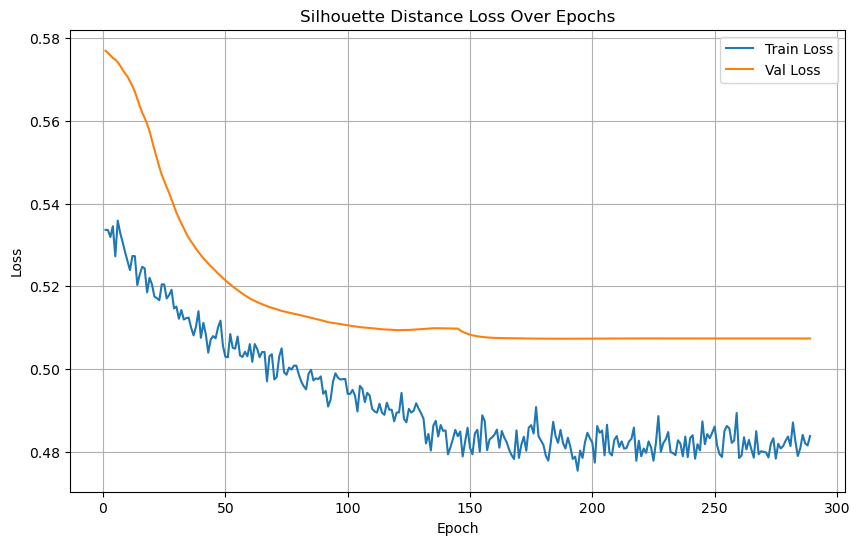

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/79], Loss: 0.3880
Test Batch [20/79], Loss: 0.1088
Test Batch [30/79], Loss: 0.4414


Test Batch [40/79], Loss: 0.3616
Test Batch [50/79], Loss: 0.3046
Test Batch [60/79], Loss: 0.4193


Test Batch [70/79], Loss: 0.3044

Test Loss: 0.3466


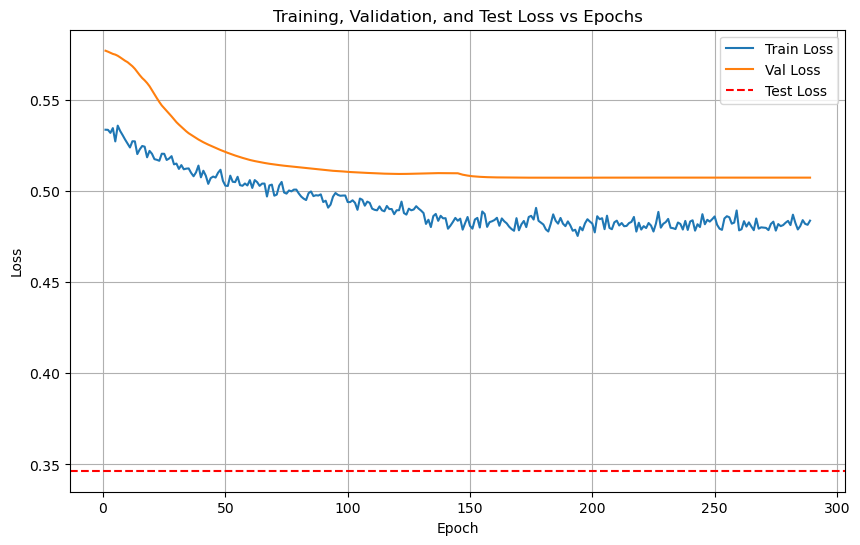

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/79 for test dataset.


  Processed batch 20/79 for test dataset.
  Processed batch 30/79 for test dataset.


  Processed batch 40/79 for test dataset.


  Processed batch 50/79 for test dataset.


  Processed batch 60/79 for test dataset.
  Processed batch 70/79 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 47.69%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.25      0.20      0.22         5
           2       0.33      0.40      0.36         5
           3       1.00      0.20      0.33         5
           4       0.67      0.80      0.73         5
           5       1.00      0.40      0.57         5
           6       0.20      0.40      0.27         5
           7       0.44      0.80      0.57         5
           8       1.00      0.80      0.89         5
           9       0.00      0.00      0.00         5
          10       1.00      0.60      0.75         5
          11       0.50      0.40      0.44         5
          12       0.80      0.80      0.80         5

    accuracy         

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5655  |  Val Loss: 2.5883
Validation loss improved from inf to 2.5883.
[Epoch 2/1000] Train Loss: 2.5576  |  Val Loss: 2.5843
Validation loss improved from 2.5883 to 2.5843.
[Epoch 3/1000] Train Loss: 2.5516  |  Val Loss: 2.5806
Validation loss improved from 2.5843 to 2.5806.
[Epoch 4/1000] Train Loss: 2.5461  |  Val Loss: 2.5769
Validation loss improved from 2.5806 to 2.5769.
[Epoch 5/1000] Train Loss: 2.5405  |  Val Loss: 2.5734
Validation loss improved from 2.5769 to 2.5734.
[Epoch 6/1000] Train Loss: 2.5360  |  Val Loss: 2.5706
Validation loss improved from 2.5734 to 2.5706.
[Epoch 7/1000] Train Loss: 2.5322  |  Val Loss: 2.5679
Validation loss improved from 2.5706 to 2.5679.
[Epoch 8/1000] Train Loss: 2.5284  |  Val Loss: 2.5652
Validation loss improved from 2.5679 to 2.5652.
[Epoch 9/1000] Train Loss: 2.5252  |  Val Loss: 2.5627
Validation loss improved from 2.5652 to 2.5627.
[Epoch 10/1000] Train Loss: 2.5221  |  Val Loss: 2.5605
Validation loss impr

[Epoch 18/1000] Train Loss: 2.5013  |  Val Loss: 2.5474
Validation loss improved from 2.5487 to 2.5474.
[Epoch 19/1000] Train Loss: 2.4986  |  Val Loss: 2.5464
Validation loss improved from 2.5474 to 2.5464.
[Epoch 20/1000] Train Loss: 2.4963  |  Val Loss: 2.5454
Validation loss improved from 2.5464 to 2.5454.
[Epoch 21/1000] Train Loss: 2.4939  |  Val Loss: 2.5444
Validation loss improved from 2.5454 to 2.5444.
[Epoch 22/1000] Train Loss: 2.4916  |  Val Loss: 2.5434
Validation loss improved from 2.5444 to 2.5434.
[Epoch 23/1000] Train Loss: 2.4892  |  Val Loss: 2.5425
Validation loss improved from 2.5434 to 2.5425.
[Epoch 24/1000] Train Loss: 2.4869  |  Val Loss: 2.5416
Validation loss improved from 2.5425 to 2.5416.
[Epoch 25/1000] Train Loss: 2.4847  |  Val Loss: 2.5407
Validation loss improved from 2.5416 to 2.5407.


[Epoch 26/1000] Train Loss: 2.4823  |  Val Loss: 2.5398
Validation loss improved from 2.5407 to 2.5398.
[Epoch 27/1000] Train Loss: 2.4799  |  Val Loss: 2.5388
Validation loss improved from 2.5398 to 2.5388.
[Epoch 28/1000] Train Loss: 2.4778  |  Val Loss: 2.5379
Validation loss improved from 2.5388 to 2.5379.
[Epoch 29/1000] Train Loss: 2.4755  |  Val Loss: 2.5368
Validation loss improved from 2.5379 to 2.5368.
[Epoch 30/1000] Train Loss: 2.4734  |  Val Loss: 2.5356
Validation loss improved from 2.5368 to 2.5356.
[Epoch 31/1000] Train Loss: 2.4709  |  Val Loss: 2.5346
Validation loss improved from 2.5356 to 2.5346.
[Epoch 32/1000] Train Loss: 2.4683  |  Val Loss: 2.5334
Validation loss improved from 2.5346 to 2.5334.
[Epoch 33/1000] Train Loss: 2.4660  |  Val Loss: 2.5321
Validation loss improved from 2.5334 to 2.5321.
[Epoch 34/1000] Train Loss: 2.4634  |  Val Loss: 2.5311
Validation loss improved from 2.5321 to 2.5311.
[Epoch 35/1000] Train Loss: 2.4612  |  Val Loss: 2.5303
Validati

[Epoch 42/1000] Train Loss: 2.4468  |  Val Loss: 2.5265
Validation loss improved from 2.5268 to 2.5265.
[Epoch 43/1000] Train Loss: 2.4445  |  Val Loss: 2.5260
Validation loss improved from 2.5265 to 2.5260.
[Epoch 44/1000] Train Loss: 2.4424  |  Val Loss: 2.5255
Validation loss improved from 2.5260 to 2.5255.
[Epoch 45/1000] Train Loss: 2.4402  |  Val Loss: 2.5250
Validation loss improved from 2.5255 to 2.5250.
[Epoch 46/1000] Train Loss: 2.4381  |  Val Loss: 2.5245
Validation loss improved from 2.5250 to 2.5245.
[Epoch 47/1000] Train Loss: 2.4361  |  Val Loss: 2.5240
Validation loss improved from 2.5245 to 2.5240.
[Epoch 48/1000] Train Loss: 2.4339  |  Val Loss: 2.5236
Validation loss improved from 2.5240 to 2.5236.
[Epoch 49/1000] Train Loss: 2.4315  |  Val Loss: 2.5232
Validation loss improved from 2.5236 to 2.5232.
[Epoch 50/1000] Train Loss: 2.4290  |  Val Loss: 2.5228
Validation loss improved from 2.5232 to 2.5228.
[Epoch 51/1000] Train Loss: 2.4261  |  Val Loss: 2.5226
Validati

[Epoch 56/1000] Train Loss: 2.4135  |  Val Loss: 2.5217
Validation loss improved from 2.5219 to 2.5217.
[Epoch 57/1000] Train Loss: 2.4116  |  Val Loss: 2.5215
Validation loss improved from 2.5217 to 2.5215.
[Epoch 58/1000] Train Loss: 2.4095  |  Val Loss: 2.5213
Validation loss improved from 2.5215 to 2.5213.
[Epoch 59/1000] Train Loss: 2.4076  |  Val Loss: 2.5211
Validation loss improved from 2.5213 to 2.5211.
[Epoch 60/1000] Train Loss: 2.4055  |  Val Loss: 2.5208
Validation loss improved from 2.5211 to 2.5208.
[Epoch 61/1000] Train Loss: 2.4037  |  Val Loss: 2.5205
Validation loss improved from 2.5208 to 2.5205.
[Epoch 62/1000] Train Loss: 2.4018  |  Val Loss: 2.5200
Validation loss improved from 2.5205 to 2.5200.
[Epoch 63/1000] Train Loss: 2.3996  |  Val Loss: 2.5195
Validation loss improved from 2.5200 to 2.5195.
[Epoch 64/1000] Train Loss: 2.3976  |  Val Loss: 2.5190
Validation loss improved from 2.5195 to 2.5190.
[Epoch 65/1000] Train Loss: 2.3956  |  Val Loss: 2.5185
Validati

[Epoch 73/1000] Train Loss: 2.3795  |  Val Loss: 2.5149
Validation loss improved from 2.5157 to 2.5149.
[Epoch 74/1000] Train Loss: 2.3776  |  Val Loss: 2.5142
Validation loss improved from 2.5149 to 2.5142.
[Epoch 75/1000] Train Loss: 2.3755  |  Val Loss: 2.5136
Validation loss improved from 2.5142 to 2.5136.
[Epoch 76/1000] Train Loss: 2.3739  |  Val Loss: 2.5132
Validation loss improved from 2.5136 to 2.5132.
[Epoch 77/1000] Train Loss: 2.3720  |  Val Loss: 2.5128
Validation loss improved from 2.5132 to 2.5128.
[Epoch 78/1000] Train Loss: 2.3701  |  Val Loss: 2.5124
Validation loss improved from 2.5128 to 2.5124.
[Epoch 79/1000] Train Loss: 2.3680  |  Val Loss: 2.5121
Validation loss improved from 2.5124 to 2.5121.
[Epoch 80/1000] Train Loss: 2.3661  |  Val Loss: 2.5117
Validation loss improved from 2.5121 to 2.5117.
[Epoch 81/1000] Train Loss: 2.3640  |  Val Loss: 2.5114
Validation loss improved from 2.5117 to 2.5114.
[Epoch 82/1000] Train Loss: 2.3619  |  Val Loss: 2.5111
Validati

[Epoch 90/1000] Train Loss: 2.3449  |  Val Loss: 2.5071
Validation loss improved from 2.5077 to 2.5071.
[Epoch 91/1000] Train Loss: 2.3426  |  Val Loss: 2.5065
Validation loss improved from 2.5071 to 2.5065.
[Epoch 92/1000] Train Loss: 2.3406  |  Val Loss: 2.5059
Validation loss improved from 2.5065 to 2.5059.
[Epoch 93/1000] Train Loss: 2.3383  |  Val Loss: 2.5054
Validation loss improved from 2.5059 to 2.5054.
[Epoch 94/1000] Train Loss: 2.3364  |  Val Loss: 2.5048
Validation loss improved from 2.5054 to 2.5048.
[Epoch 95/1000] Train Loss: 2.3344  |  Val Loss: 2.5042
Validation loss improved from 2.5048 to 2.5042.
[Epoch 96/1000] Train Loss: 2.3324  |  Val Loss: 2.5038
Validation loss improved from 2.5042 to 2.5038.
[Epoch 97/1000] Train Loss: 2.3303  |  Val Loss: 2.5033
Validation loss improved from 2.5038 to 2.5033.
[Epoch 98/1000] Train Loss: 2.3285  |  Val Loss: 2.5033
Validation loss improved from 2.5033 to 2.5033.
[Epoch 99/1000] Train Loss: 2.3264  |  Val Loss: 2.5040
!! Valid

[Epoch 103/1000] Train Loss: 2.3170  |  Val Loss: 2.5037
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 104/1000] Train Loss: 2.3147  |  Val Loss: 2.5039
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 105/1000] Train Loss: 2.3125  |  Val Loss: 2.5041
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 106/1000] Train Loss: 2.3104  |  Val Loss: 2.5041
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 107/1000] Train Loss: 2.3083  |  Val Loss: 2.5039
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 108/1000] Train Loss: 2.3064  |  Val Loss: 2.5036
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 109/1000] Train Loss: 2.3043  |  Val Loss: 2.5031
Validation loss improved from 2.5033 to 2.5031.
[Epoch 110/1000] Train Loss: 2.3020  |  Val Loss: 2.5024
Validation loss improved from 2.5031 to 2.5024.
[Epoch 111/1000] Train Loss: 2.2999  |  Val Loss: 2.5022
Validation loss improved from 2.5024 to 2.5022.
[Epoch 112/1000] T

[Epoch 121/1000] Train Loss: 2.2770  |  Val Loss: 2.4987
Validation loss improved from 2.4994 to 2.4987.
[Epoch 122/1000] Train Loss: 2.2748  |  Val Loss: 2.4980
Validation loss improved from 2.4987 to 2.4980.
[Epoch 123/1000] Train Loss: 2.2725  |  Val Loss: 2.4975
Validation loss improved from 2.4980 to 2.4975.
[Epoch 124/1000] Train Loss: 2.2703  |  Val Loss: 2.4970
Validation loss improved from 2.4975 to 2.4970.
[Epoch 125/1000] Train Loss: 2.2682  |  Val Loss: 2.4967
Validation loss improved from 2.4970 to 2.4967.
[Epoch 126/1000] Train Loss: 2.2662  |  Val Loss: 2.4963
Validation loss improved from 2.4967 to 2.4963.
[Epoch 127/1000] Train Loss: 2.2641  |  Val Loss: 2.4956
Validation loss improved from 2.4963 to 2.4956.
[Epoch 128/1000] Train Loss: 2.2620  |  Val Loss: 2.4949
Validation loss improved from 2.4956 to 2.4949.
[Epoch 129/1000] Train Loss: 2.2600  |  Val Loss: 2.4945
Validation loss improved from 2.4949 to 2.4945.
[Epoch 130/1000] Train Loss: 2.2579  |  Val Loss: 2.494

[Epoch 135/1000] Train Loss: 2.2453  |  Val Loss: 2.4937
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 136/1000] Train Loss: 2.2429  |  Val Loss: 2.4950
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 137/1000] Train Loss: 2.2406  |  Val Loss: 2.4957
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 138/1000] Train Loss: 2.2382  |  Val Loss: 2.4959
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 139/1000] Train Loss: 2.2359  |  Val Loss: 2.4957
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 140/1000] Train Loss: 2.2337  |  Val Loss: 2.4952
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 141/1000] Train Loss: 2.2315  |  Val Loss: 2.4945
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 142/1000] Train Loss: 2.2292  |  Val Loss: 2.4937
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 143/1000] Train Loss: 2.2270  |  Val Loss: 2.4929
Validation loss improved from 2.4935 to 2.4929.
[Epoch 

[Epoch 153/1000] Train Loss: 2.2028  |  Val Loss: 2.4890
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 154/1000] Train Loss: 2.2002  |  Val Loss: 2.4894
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 155/1000] Train Loss: 2.1980  |  Val Loss: 2.4893
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 156/1000] Train Loss: 2.1958  |  Val Loss: 2.4889
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 157/1000] Train Loss: 2.1936  |  Val Loss: 2.4885
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 158/1000] Train Loss: 2.1914  |  Val Loss: 2.4879
Validation loss improved from 2.4885 to 2.4879.
[Epoch 159/1000] Train Loss: 2.1888  |  Val Loss: 2.4871
Validation loss improved from 2.4879 to 2.4871.
[Epoch 160/1000] Train Loss: 2.1865  |  Val Loss: 2.4859
Validation loss improved from 2.4871 to 2.4859.
[Epoch 161/1000] Train Loss: 2.1836  |  Val Loss: 2.4844
Validation loss improved from 2.4859 to 2.4844.
[Epoch 162/1000] Train Lo

[Epoch 168/1000] Train Loss: 2.1664  |  Val Loss: 2.4790
Validation loss improved from 2.4794 to 2.4790.
[Epoch 169/1000] Train Loss: 2.1639  |  Val Loss: 2.4796
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 170/1000] Train Loss: 2.1617  |  Val Loss: 2.4796
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 171/1000] Train Loss: 2.1593  |  Val Loss: 2.4795
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 172/1000] Train Loss: 2.1570  |  Val Loss: 2.4791
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 173/1000] Train Loss: 2.1548  |  Val Loss: 2.4787
Validation loss improved from 2.4790 to 2.4787.
[Epoch 174/1000] Train Loss: 2.1525  |  Val Loss: 2.4781
Validation loss improved from 2.4787 to 2.4781.
[Epoch 175/1000] Train Loss: 2.1502  |  Val Loss: 2.4773
Validation loss improved from 2.4781 to 2.4773.
[Epoch 176/1000] Train Loss: 2.1478  |  Val Loss: 2.4766
Validation loss improved from 2.4773 to 2.4766.
[Epoch 177/1000] Train Loss: 2.

[Epoch 188/1000] Train Loss: 2.1167  |  Val Loss: 2.4729
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 189/1000] Train Loss: 2.1137  |  Val Loss: 2.4737
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 190/1000] Train Loss: 2.1110  |  Val Loss: 2.4742
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 191/1000] Train Loss: 2.1085  |  Val Loss: 2.4755
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 192/1000] Train Loss: 2.1057  |  Val Loss: 2.4788
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 193/1000] Train Loss: 2.1033  |  Val Loss: 2.4825
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 194/1000] Train Loss: 2.1009  |  Val Loss: 2.4862
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 195/1000] Train Loss: 2.0985  |  Val Loss: 2.4901
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 196/1000] Train Loss: 2.0961  |  Val Loss: 2.4922
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 199/1000] Train Loss: 2.0870  |  Val Loss: 2.4836
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 200/1000] Train Loss: 2.0843  |  Val Loss: 2.4803
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 201/1000] Train Loss: 2.0814  |  Val Loss: 2.4775
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 202/1000] Train Loss: 2.0788  |  Val Loss: 2.4752
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 203/1000] Train Loss: 2.0764  |  Val Loss: 2.4733
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 204/1000] Train Loss: 2.0740  |  Val Loss: 2.4720
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 205/1000] Train Loss: 2.0716  |  Val Loss: 2.4709
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 206/1000] Train Loss: 2.0691  |  Val Loss: 2.4696
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 207/1000] Train Loss: 2.0666  |  Val Loss: 2.4685
Validation loss improved from 2.4696 to 2.4685.

[Epoch 215/1000] Train Loss: 2.0429  |  Val Loss: 2.4686
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 216/1000] Train Loss: 2.0398  |  Val Loss: 2.4668
Validation loss improved from 2.4682 to 2.4668.
[Epoch 217/1000] Train Loss: 2.0366  |  Val Loss: 2.4653
Validation loss improved from 2.4668 to 2.4653.
[Epoch 218/1000] Train Loss: 2.0337  |  Val Loss: 2.4641
Validation loss improved from 2.4653 to 2.4641.
[Epoch 219/1000] Train Loss: 2.0306  |  Val Loss: 2.4631
Validation loss improved from 2.4641 to 2.4631.
[Epoch 220/1000] Train Loss: 2.0276  |  Val Loss: 2.4627
Validation loss improved from 2.4631 to 2.4627.
[Epoch 221/1000] Train Loss: 2.0245  |  Val Loss: 2.4630
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 222/1000] Train Loss: 2.0215  |  Val Loss: 2.4627
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 223/1000] Train Loss: 2.0185  |  Val Loss: 2.4621
Validation loss improved from 2.4627 to 2.4621.
[Epoch 224/1000] Train Loss: 2.0156  

[Epoch 228/1000] Train Loss: 2.0036  |  Val Loss: 2.4687
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 229/1000] Train Loss: 2.0008  |  Val Loss: 2.4700
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 230/1000] Train Loss: 1.9981  |  Val Loss: 2.4714
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 231/1000] Train Loss: 1.9952  |  Val Loss: 2.4738
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 232/1000] Train Loss: 1.9922  |  Val Loss: 2.4751
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 233/1000] Train Loss: 1.9892  |  Val Loss: 2.4755
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 234/1000] Train Loss: 1.9860  |  Val Loss: 2.4758
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 235/1000] Train Loss: 1.9828  |  Val Loss: 2.4787
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 236/1000] Train Loss: 1.9798  |  Val Loss: 2.4833
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 244/1000] Train Loss: 1.9546  |  Val Loss: 2.4789
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 245/1000] Train Loss: 1.9512  |  Val Loss: 2.4772
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 246/1000] Train Loss: 1.9482  |  Val Loss: 2.4756
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 247/1000] Train Loss: 1.9453  |  Val Loss: 2.4739
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 248/1000] Train Loss: 1.9421  |  Val Loss: 2.4726
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 249/1000] Train Loss: 1.9391  |  Val Loss: 2.4712
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 250/1000] Train Loss: 1.9361  |  Val Loss: 2.4695
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 251/1000] Train Loss: 1.9326  |  Val Loss: 2.4679
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 252/1000] Train Loss: 1.9294  |  Val Loss: 2.4665
!! Validation loss did NOT improve !! Patience:

[Epoch 259/1000] Train Loss: 1.9083  |  Val Loss: 2.4474
Validation loss improved from 2.4495 to 2.4474.
[Epoch 260/1000] Train Loss: 1.9053  |  Val Loss: 2.4456
Validation loss improved from 2.4474 to 2.4456.
[Epoch 261/1000] Train Loss: 1.9022  |  Val Loss: 2.4439
Validation loss improved from 2.4456 to 2.4439.
[Epoch 262/1000] Train Loss: 1.8990  |  Val Loss: 2.4426
Validation loss improved from 2.4439 to 2.4426.
[Epoch 263/1000] Train Loss: 1.8956  |  Val Loss: 2.4417
Validation loss improved from 2.4426 to 2.4417.
[Epoch 264/1000] Train Loss: 1.8919  |  Val Loss: 2.4426
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 265/1000] Train Loss: 1.8881  |  Val Loss: 2.4463
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 266/1000] Train Loss: 1.8841  |  Val Loss: 2.4488
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 267/1000] Train Loss: 1.8806  |  Val Loss: 2.4503
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 268/1000] Train Loss: 1.

[Epoch 276/1000] Train Loss: 1.8507  |  Val Loss: 2.4541
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 277/1000] Train Loss: 1.8472  |  Val Loss: 2.4542
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 278/1000] Train Loss: 1.8441  |  Val Loss: 2.4542
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 279/1000] Train Loss: 1.8410  |  Val Loss: 2.4547
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 280/1000] Train Loss: 1.8380  |  Val Loss: 2.4544
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 281/1000] Train Loss: 1.8345  |  Val Loss: 2.4534
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 282/1000] Train Loss: 1.8308  |  Val Loss: 2.4522
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 283/1000] Train Loss: 1.8274  |  Val Loss: 2.4523
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 284/1000] Train Loss: 1.8240  |  Val Loss: 2.4539
!! Validation loss did NOT improve !! Patience:

[Epoch 291/1000] Train Loss: 1.8020  |  Val Loss: 2.4531
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 292/1000] Train Loss: 1.7991  |  Val Loss: 2.4540
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 293/1000] Train Loss: 1.7965  |  Val Loss: 2.4539
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 294/1000] Train Loss: 1.7940  |  Val Loss: 2.4535
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 295/1000] Train Loss: 1.7911  |  Val Loss: 2.4535
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 296/1000] Train Loss: 1.7883  |  Val Loss: 2.4547
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 297/1000] Train Loss: 1.7851  |  Val Loss: 2.4550
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 298/1000] Train Loss: 1.7821  |  Val Loss: 2.4546
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 299/1000] Train Loss: 1.7789  |  Val Loss: 2.4548
!! Validation loss did NOT improve !! Patience:

[Epoch 304/1000] Train Loss: 1.7635  |  Val Loss: 2.4566
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 305/1000] Train Loss: 1.7608  |  Val Loss: 2.4564
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 306/1000] Train Loss: 1.7581  |  Val Loss: 2.4557
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 307/1000] Train Loss: 1.7550  |  Val Loss: 2.4546
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 308/1000] Train Loss: 1.7520  |  Val Loss: 2.4531
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 309/1000] Train Loss: 1.7495  |  Val Loss: 2.4514
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 310/1000] Train Loss: 1.7466  |  Val Loss: 2.4493
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 311/1000] Train Loss: 1.7438  |  Val Loss: 2.4475
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 312/1000] Train Loss: 1.7410  |  Val Loss: 2.4468
!! Validation loss did NOT improve !! Patience:

[Epoch 325/1000] Train Loss: 1.7024  |  Val Loss: 2.4562
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 326/1000] Train Loss: 1.6994  |  Val Loss: 2.4577
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 327/1000] Train Loss: 1.6963  |  Val Loss: 2.4567
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 328/1000] Train Loss: 1.6930  |  Val Loss: 2.4560
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 329/1000] Train Loss: 1.6900  |  Val Loss: 2.4565
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 330/1000] Train Loss: 1.6866  |  Val Loss: 2.4561
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 331/1000] Train Loss: 1.6836  |  Val Loss: 2.4554
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 332/1000] Train Loss: 1.6801  |  Val Loss: 2.4558
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 333/1000] Train Loss: 1.6770  |  Val Loss: 2.4577
!! Validation loss did NOT improve !! Patience:

[Epoch 337/1000] Train Loss: 1.6641  |  Val Loss: 2.4662
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 338/1000] Train Loss: 1.6606  |  Val Loss: 2.4666
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 339/1000] Train Loss: 1.6573  |  Val Loss: 2.4674
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 340/1000] Train Loss: 1.6540  |  Val Loss: 2.4679
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 341/1000] Train Loss: 1.6510  |  Val Loss: 2.4677
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 342/1000] Train Loss: 1.6478  |  Val Loss: 2.4676
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 343/1000] Train Loss: 1.6445  |  Val Loss: 2.4690
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 344/1000] Train Loss: 1.6415  |  Val Loss: 2.4722
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 345/1000] Train Loss: 1.6386  |  Val Loss: 2.4746
!! Validation loss did NOT improve !! Patience:

[Epoch 358/1000] Train Loss: 1.6010  |  Val Loss: 2.4710
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 359/1000] Train Loss: 1.5982  |  Val Loss: 2.4743
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 360/1000] Train Loss: 1.5956  |  Val Loss: 2.4797
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 361/1000] Train Loss: 1.5930  |  Val Loss: 2.4837
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 362/1000] Train Loss: 1.5898  |  Val Loss: 2.4862
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 363/1000] Train Loss: 1.5869  |  Val Loss: 2.4887
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 363 !!
No improvement for 100 epochs.


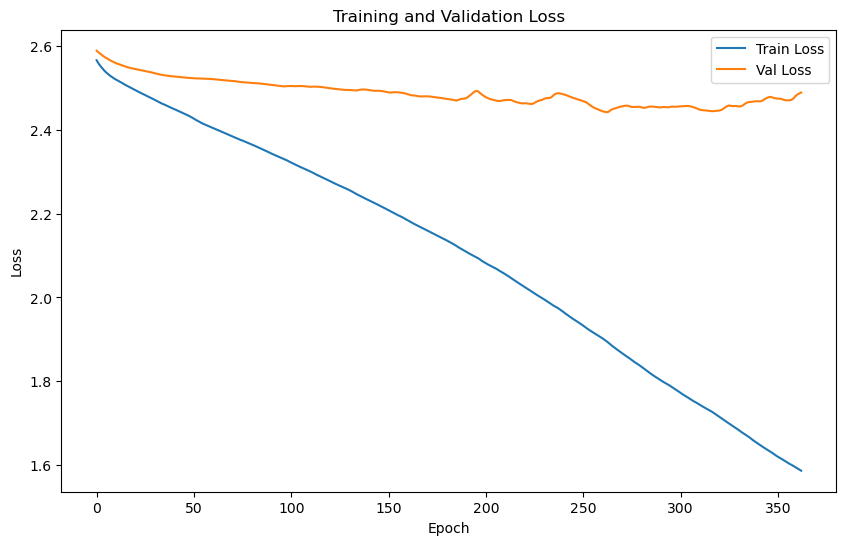

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.1517 | Test Accuracy: 38.66%


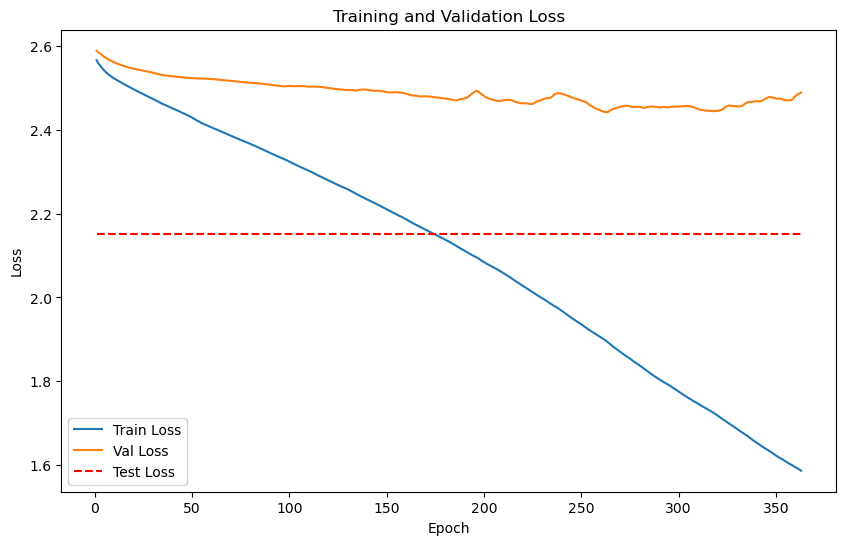

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


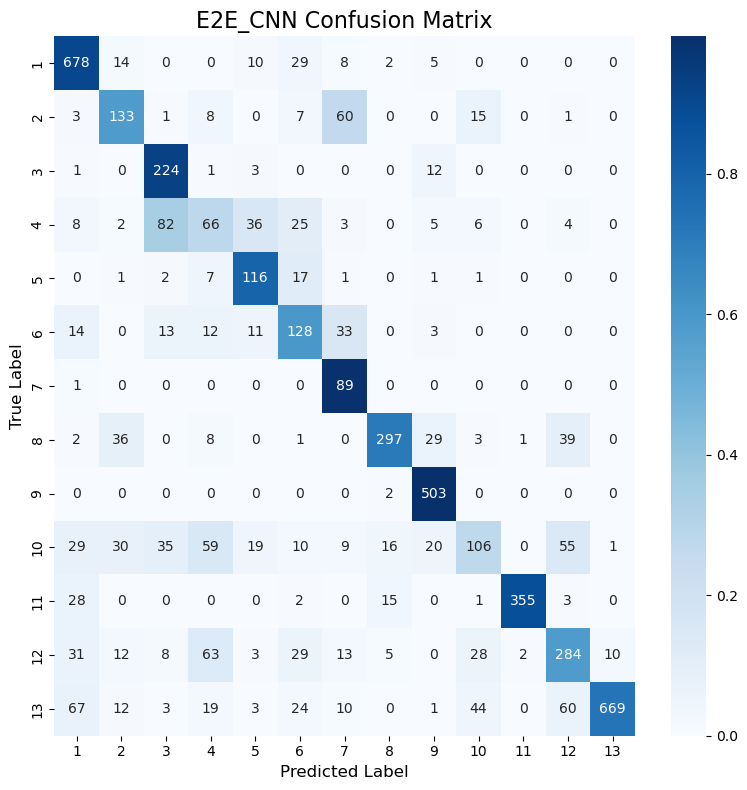

Classification Accuracy: 72.73%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


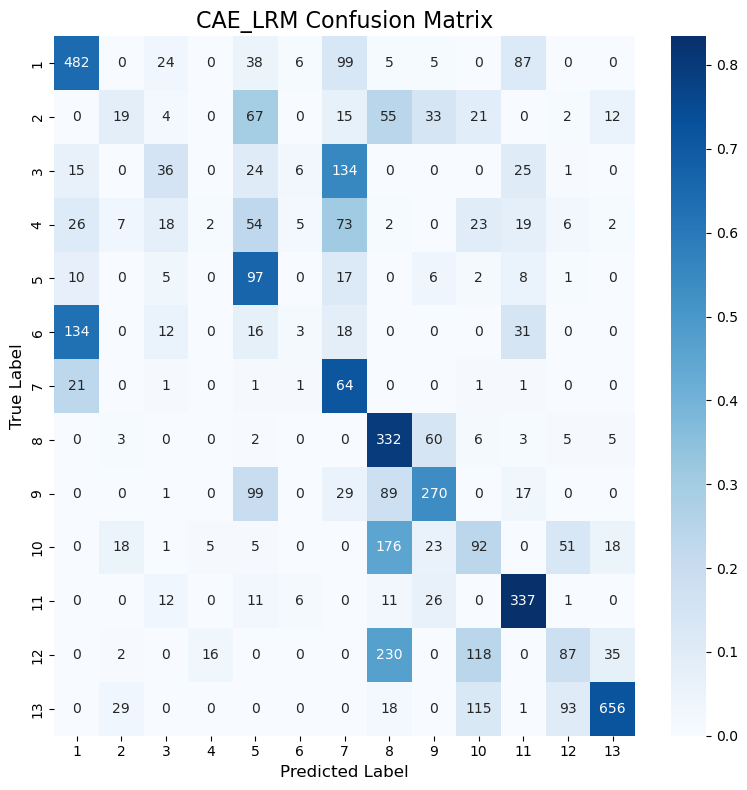

Classification Accuracy: 49.38%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


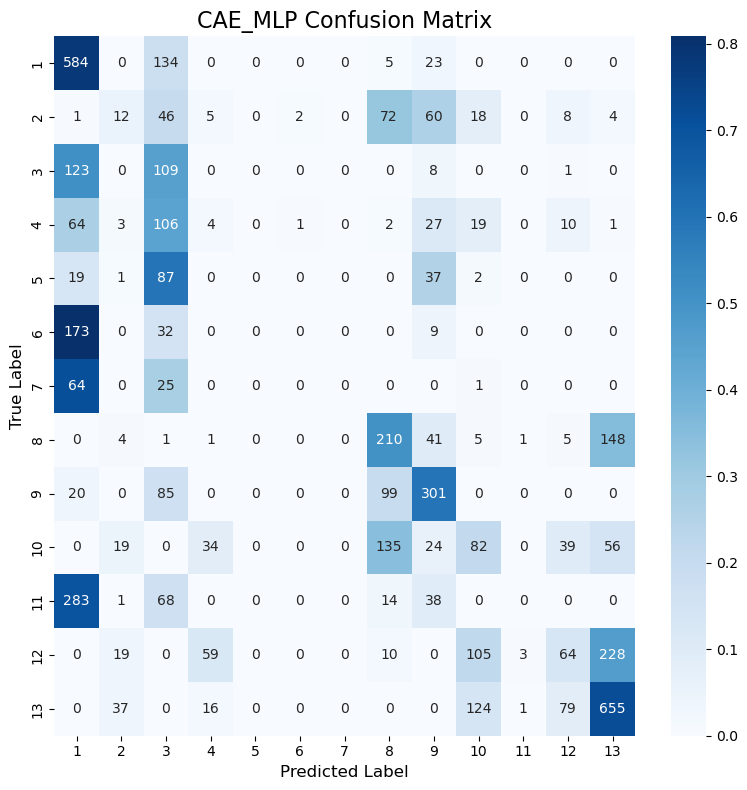

Classification Accuracy: 40.29%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


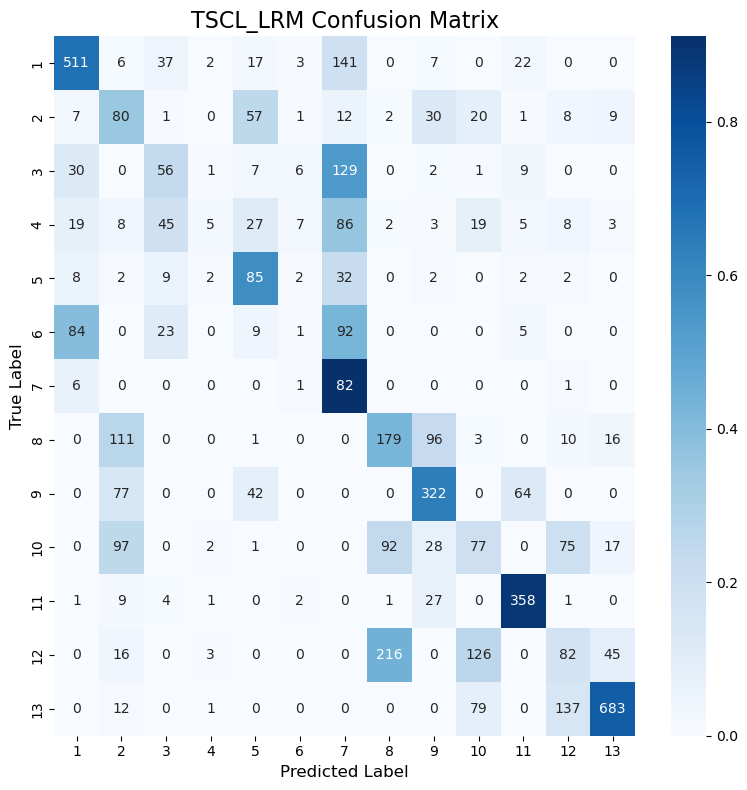

Classification Accuracy: 50.26%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


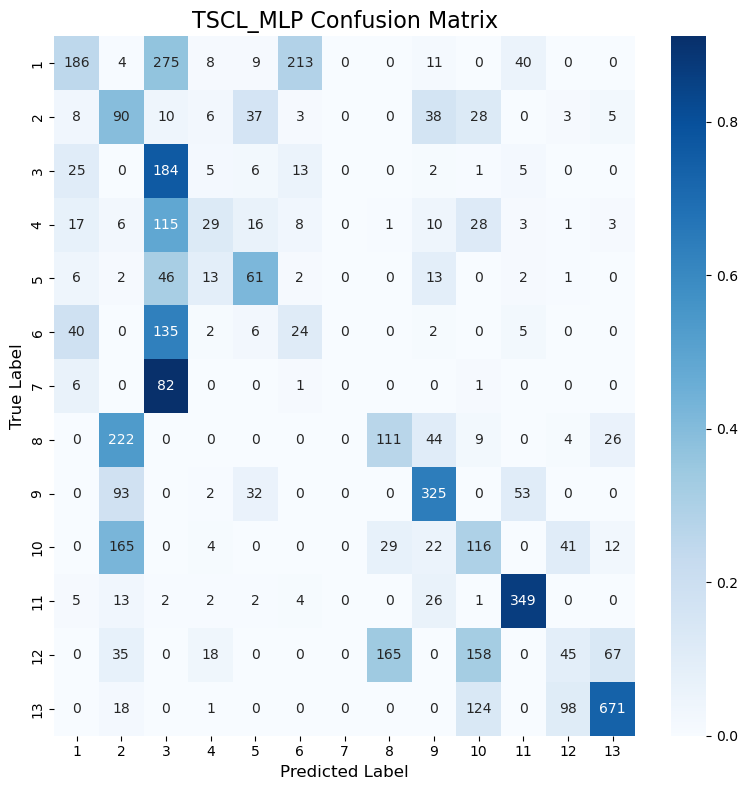

Classification Accuracy: 43.68%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


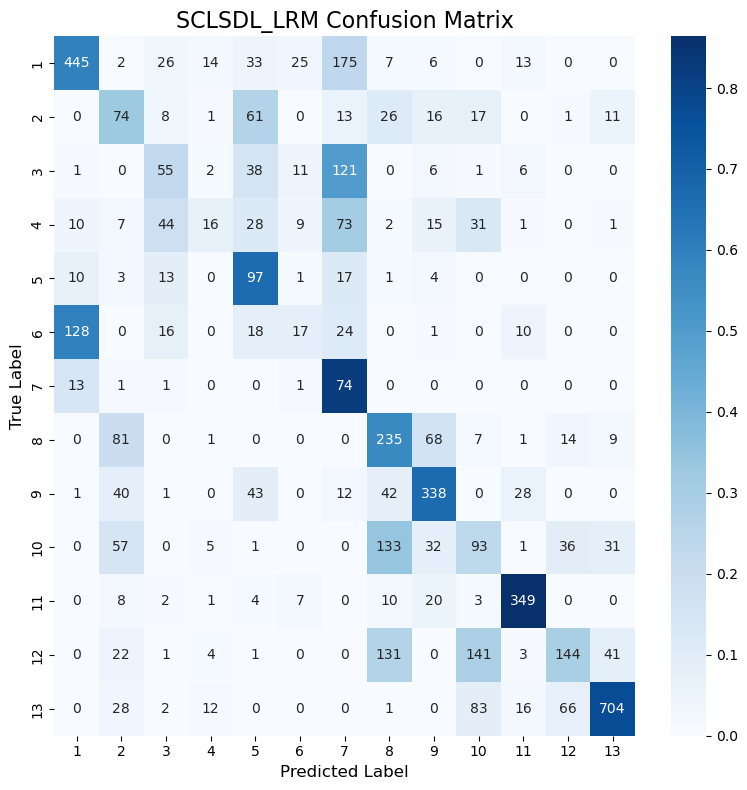

Classification Accuracy: 52.65%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


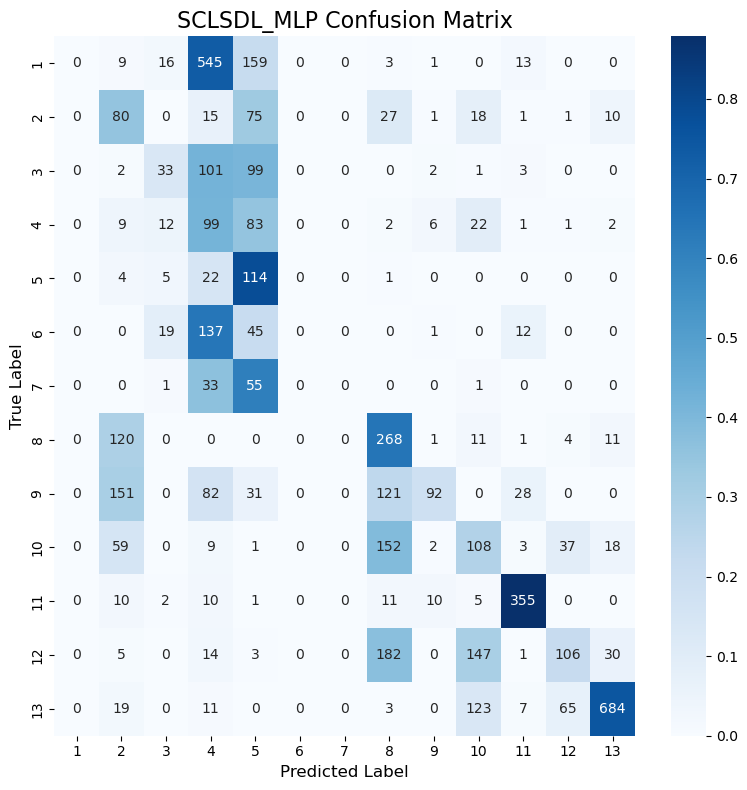

Classification Accuracy: 38.66%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          72.73
1    LRM (CAE)          49.38
2    MLP (CAE)          40.29
3     TSCL LRM          50.26
4     TSCL MLP          43.68
5  SCL_SDL LRM          52.65
6  SCL_SDL MLP          38.66

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          72.73
5  SCL_SDL LRM          52.65
3     TSCL LRM          50.26
1    LRM (CAE)          49.38
4     TSCL MLP          43.68
2    MLP (CAE)          40.29
6  SCL_SDL MLP          38.66
